<a name="top"></a>
<div class="alert alert-info" style="text-align:center">
<h1 > Guide to Long-Slit Spectral Extractions </h1>
<h3 > by Robert Quimby (SDSU) </h3>
</div>

This Jupyter notebook supplements the spectroscopy lesson from the GROWTH Summer School 2020 and serves as a complete guide to long-slit spectral extractions.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-school-2020.html

## Process

- [Step 0](#step0) - Image Processing
- [Step 1](#step1) - Find the (Initial) 1-D Wavelength Solution
- [Step 2](#step2) - Find the 2-D Wavelength Solution
- [Step 3](#step3) - Flat Field the 2D Spectra (Optional)
- [Step 4](#step4) - Model the 2D Sky
- [Step 5](#step5) - Extract the 1-D Target Spectrum
- [Step 6](#step6) - Tweak the Wavelength Solution Using Sky Lines
- [Step 7](#step7) - Flux Calibration (Optional)
- [Step 8](#step8) - Removal of Telluric Features (Optional) 

## Required Python modules
* python 3
* `astropy`
* `numpy`
* `scipy`
* `matplotlib`

In [1]:
# python modules that we will use
import os
from glob import glob
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
from scipy.interpolate import interp1d, LSQUnivariateSpline, LSQBivariateSpline
from scipy.optimize import fmin, curve_fit
from scipy.signal import find_peaks

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
from platform import python_version
assert python_version() >= '3.6', "Python version 3.6 or greater is required for f-strings"

import scipy
assert scipy.__version__ >= '1.4', "scipy version 1.4 or higher is required for this module"

In [3]:
# change plotting defaults
plt.rc('axes', labelsize=14)
plt.rc('axes', labelweight='bold')
plt.rc('axes', titlesize=16)
plt.rc('axes', titleweight='bold')
plt.rc('font', family='sans-serif')
plt.rcParams['figure.figsize'] = (17, 7)

In [4]:
# where are the data located?
cwd = os.getcwd()
data_dir = os.path.join(cwd, 'data')

<a name="step0">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 0: Image Processing
    </h1>
</a>

The 2-D spectral images must be processed to remove bias. Just as with other CCD imaging data, overscan should be removed and (for best results) the residual 2-D bias should be subtracted.

For display purposes it is also convienent to transpose the images (if necessary) so that wavelength increases to the right, but this is not a requirement. 

The example data provided have already been overscan subtracted and transposed, so if you are starting with these, no actions are required for this step.

Let's begin by looking at the processed 2D image of the science spectrum, `spec_sci.fits`.

In [5]:
# load the 2D science image data
image = fits.getdata(os.path.join(data_dir,'spec_sci.fits'))

# get the a pixel coordinate near the image center (for later use)
ny, nx = image.shape
cy, cx = ny//2, nx//2

# create 1d arays of the possible x and y values (for later use)
xs = np.arange(nx)
ys = np.arange(ny)

# pixel coordinates for each pixel (for later use)
yvals, xvals = np.indices(image.shape)

In [6]:
# this is a helper function to display images in this notebook
def show_image(image, lower=-1, upper=3, extent=None):
    sample = sigma_clip(image)
    vmin = sample.mean() + lower * sample.std()
    vmax = sample.mean() + upper * sample.std()
    plt.figure(figsize=(15, 3))
    plt.imshow(image, origin='lower', cmap='gray', aspect='auto', vmin=vmin, vmax=vmax, extent=extent)
    plt.xlabel('Column Number')
    plt.ylabel('Row Number');

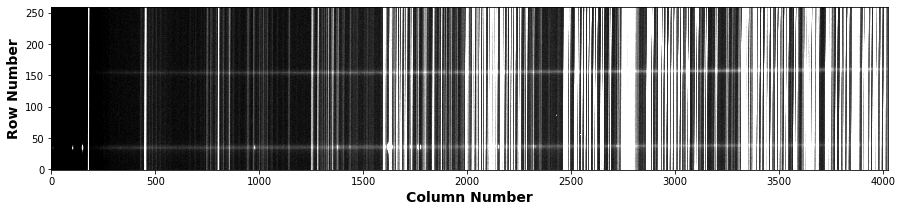

In [7]:
# display the image
show_image(image)

<a name="step1">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 1: Find the (Initial) 1-D Wavelength Solution
    </h1>
</a>

Recall that when you extract photometry from images you use different flat-field images to process your science frames depending on the filter used (e.g., you use the r-band flat-field to process r-band science frames). The same idea holds for spectroscopy except each 2-D spectral image contains a range of wavelengths. Thus it helps to first (roughly) identify the effective wavelength of each pixel before you start the extraction process. Because you may have thousands of unique wavelength bands on each 2-D spectral image, this can be the most time consuming step in the whole process. But once you set the pixel wavelengths, you will have reduced the task of spectral extraction to simple photometric extraction (but on an industrial scale). 

To begin, it helps to use arc-lamp spectra, which produce a set of emission lines of known wavelengths. By matching up the features you observed to an atlas of the expected features (with known wavelengths), you can create a mapping between pixel column and row numbers to wavelengths in angstroms.

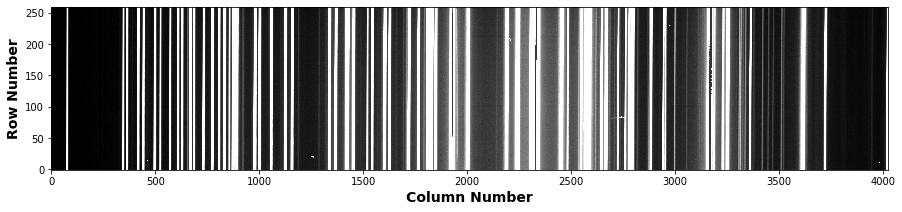

In [8]:
# load the 2D lamp image data
lamp_image = fits.getdata(os.path.join(data_dir,'spec_lamp.fits'))
show_image(lamp_image)

You should see that the lamp spectra consist of emission lines from the excited gas in the arc lamps (in this case mostly a combination of Neon and Argon). The wavelengths of these lines have been precisely measured in laboratory experiments, and we can use these known wavelengths and the columns where they are found to construct our wavelength solution. 

## Load the comparison line list

In [9]:
# load the "linelist" with precise laboratory wavelengths for these lamp lines
dtype = [('wav', float), ('id', 'U2')]
linelist = np.genfromtxt(os.path.join(data_dir, 'line_list.dat'), dtype=dtype)
linelist.sort(order='wav')

## Extract the lamp spectra from a few rows near the middle

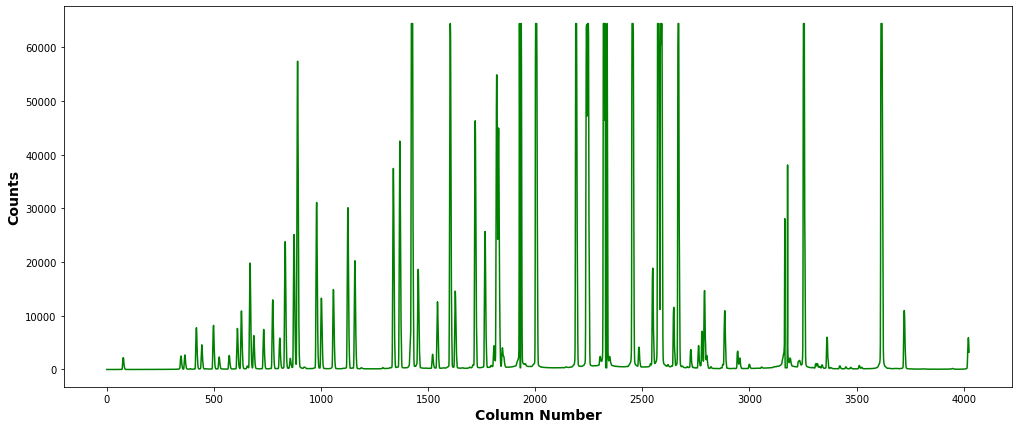

In [10]:
# simple average of each column over a few rows
row1 = cy - 5
row2 = cy + 5
lamp_spec = lamp_image[row1:row2, :].mean(axis=0)
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts');

Notice that many of the lines peak at about 65000 counts? This indicates that these lines are saturated (too bright) and will not be useful for determining the wavelength solution.

## Identify each column where the flux peaks

We need the column value where each line peaks for our column to wavelength mapping. To start we can get approximate column values using `scipy.signal.find_peaks`. The keyword `prominence` is the desired minimum contrast (in counts) between the value at a peak and the value at the nearest troughs. Set this so that significant lines are kept but noise peaks are rejected. 

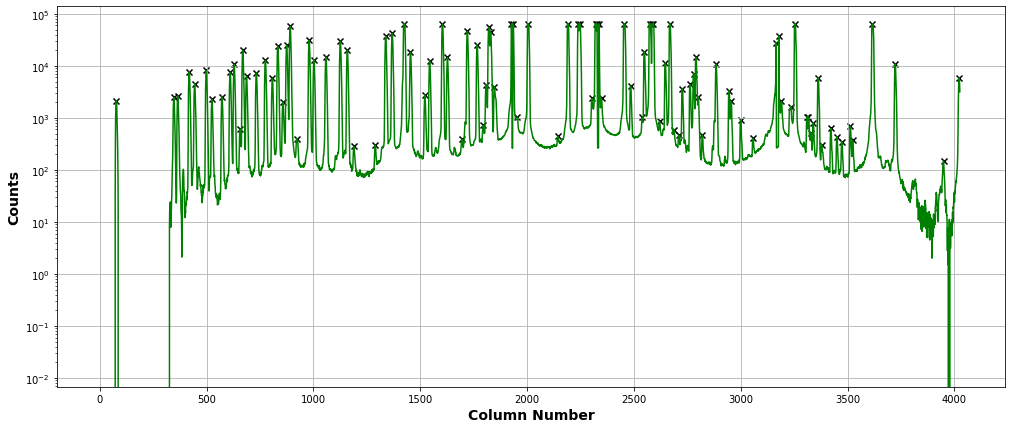

In [11]:
# locate approximate line centers
prominence = 100
peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

# plot the spectra
plt.plot(lamp_spec, c='g')

# mark the peaks
plt.scatter(peak_cols, lamp_spec[peak_cols], marker='x', c='k')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.yscale('log')
plt.grid();

The `find_peaks` function merely returns integer indices into the `lamp_spec` array. We can fit Gaussian models to each one of these peaks to find the line centers to much better than 1 column. 

In [12]:
# use a Gaussian function to model spectral lines
def gaussian(x, *params):
    amp, x0, sigma = params
    return amp * np.exp(-(x - x0)**2 / 2 / sigma**2)

In [13]:
# define a function to determine the precise column centers for each lamp line
def get_lamp_lines(lamp_spec, prominence=100):
    peak_cols, properties = find_peaks(lamp_spec, prominence=prominence)

    # record in a structured array for convenience 
    dtype = []
    dtype.append( ('col', float) )
    dtype.append( ('counts', float) )
    dtype.append( ('x', float) )
    dtype.append( ('y', float) )
    dtype.append( ('sigma', float) )
    dtype.append( ('id', 'U2') )
    dtype.append( ('wav', float) )
    dtype.append( ('wavres', float) )
    dtype.append( ('used', bool) )
    lamp_lines = np.zeros(peak_cols.size, dtype=dtype)
    lamp_lines['col'] = peak_cols
    lamp_lines['counts'] = lamp_spec[peak_cols]
    lamp_lines['x'] = np.nan
    lamp_lines['y'] = np.nan
    lamp_lines['sigma'] = np.nan
    lamp_lines['wav'] = np.nan
    lamp_lines['wavres'] = np.nan

    # fit each peak to determine precise center
    cols = np.arange(lamp_spec.size)
    sigma_guess = 2.5
    for line in lamp_lines:
        if line['counts'] > 60000:
            # line is saturated...skip
            continue

        i0 = max([0, int(line['col'] - 5)])
        i1 = min([lamp_spec.size - 1, int(line['col'] + 5)])
        guess = (line['counts'], line['col'], sigma_guess)
        bounds = ((0, line['col'] - 3, 0), (np.inf, line['col'] + 3, np.inf))
        try:
            popt, pcov = curve_fit(gaussian, cols[i0:i1], lamp_spec[i0:i1], p0=guess, bounds=bounds)
        except RuntimeError:
            # curve_fit failed to converge...skip
            continue

        line['x'] = popt[1]
        line['y'] = gaussian(popt[1], *popt)
        line['sigma'] = popt[2]

    # filter lamp_lines to keep only lines that were fit
    wasfit = np.isfinite(lamp_lines['x'])
    lamp_lines = lamp_lines[wasfit]
    print('found center pixel values for', lamp_lines.size, 'lines')
    return lamp_lines

In [14]:
# helper function to mark lamp lines with and 'x'
def mark_peaks(plt, lamp_lines, xtype='x', ytype='y', c='k'):
    w = np.isfinite(lamp_lines['wav'])
    if w.sum() > 0:
        plt.scatter(lamp_lines[xtype][w], lamp_lines[ytype][w], c=np.abs(lamp_lines['wavres'][w]), zorder=10)
    if (~w).sum() > 0:
        plt.scatter(lamp_lines[xtype][~w], lamp_lines[ytype][~w], c=c, marker='x')

found center pixel values for 82 lines


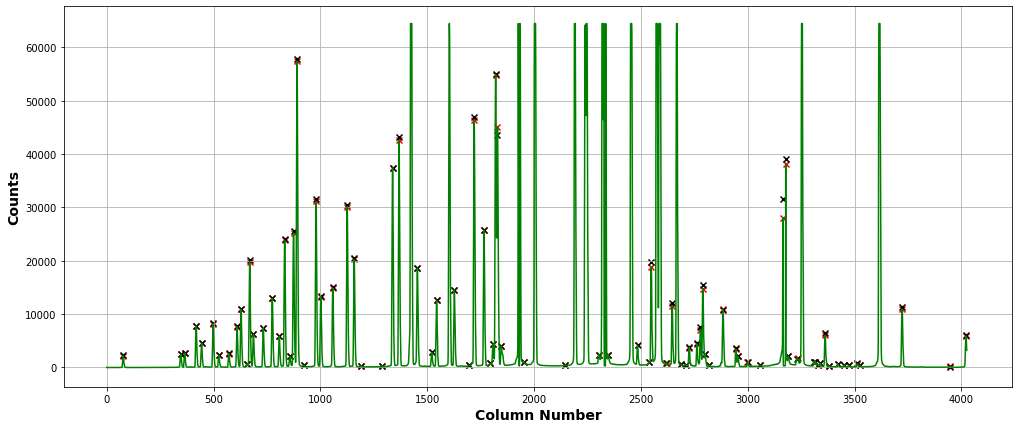

In [15]:
# find the precise column centers for all lamp lines
lamp_lines = get_lamp_lines(lamp_spec, prominence=prominence)

# plot the lamp spectra
plt.plot(lamp_spec, c='g')
plt.xlabel('Column Number')
plt.ylabel('Counts')
plt.grid()

# mark initial values from find_peaks in red
mark_peaks(plt, lamp_lines, 'col', 'counts', c='r')

# mark best-fit values
mark_peaks(plt, lamp_lines)

## Load reference spectrum

Now that we have precise column centers for each line, we need to identify each line to set its wavelength. We can begin by looking for similar line features in a wavelength calibrated lamp spectrum atlas. 

For the example Keck/LRIS spectra provided, a reference lamp spectrum is available in the `lamp_reference.dat` file. This may also work for other low-resolution spectrographs using similar arc lamps (primarily Ne, Ar). 

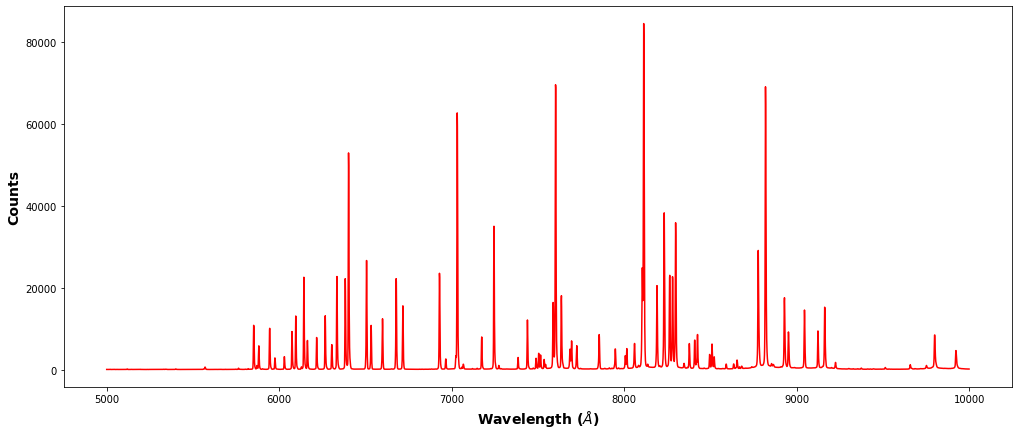

In [16]:
# load and plot the provided spectral atlas
lamp_ref = np.genfromtxt(os.path.join(data_dir, 'lamp_reference.dat'), names='wav, counts')
plt.plot(lamp_ref['wav'], lamp_ref['counts'], c='r')
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

## Define a rough mapping between column number and wavelength

In [17]:
# this function will be used below to match a given line to a given list
def match_to_list(listing, values, plt=None, tol=None, revcoeff=None, c='k'):
    matched = []
    cols = []
    for value in values:
        absdiff = np.abs(value - listing)
        ind = np.argmin(absdiff)
        if tol is None:
            bestmatch = listing[ind]
        elif absdiff[ind] < tol:
            bestmatch = listing[ind]
        else:
            bestmatch = np.nan
        matched.append(bestmatch)

        if plt is not None:
            plt.axvline(bestmatch, ls='dotted', c=c)
            
        if revcoeff is not None:
            col = np.polyval(revcoeff, bestmatch)
            cols.append(col)
            print(f"{bestmatch:.1f} is expected near column {col:.0f}")

    if revcoeff is not None:
        return np.array(matched), cols
    
    return np.array(matched)

Focus on a small wavelength range of the reference spectrum (between `wav1` and `wav2`). Pick a few good (non-blended) lines to start with.

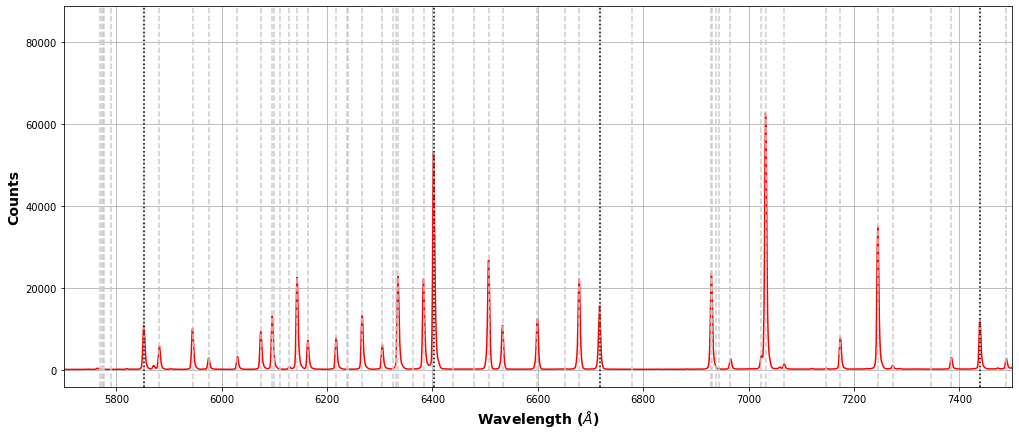

In [18]:
wav1 = 5700
wav2 = 7500

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts'); plt.grid();

# mark all wavelengths available in linelist
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick a few lines in this plot
rough_waves = [5850, 6410, 6730, 7450]
refwavs = match_to_list(linelist['wav'], rough_waves, plt=plt)

Now try to find a section of your `lamp_spec` (between columns `col1` and `col2`) that looks similar.

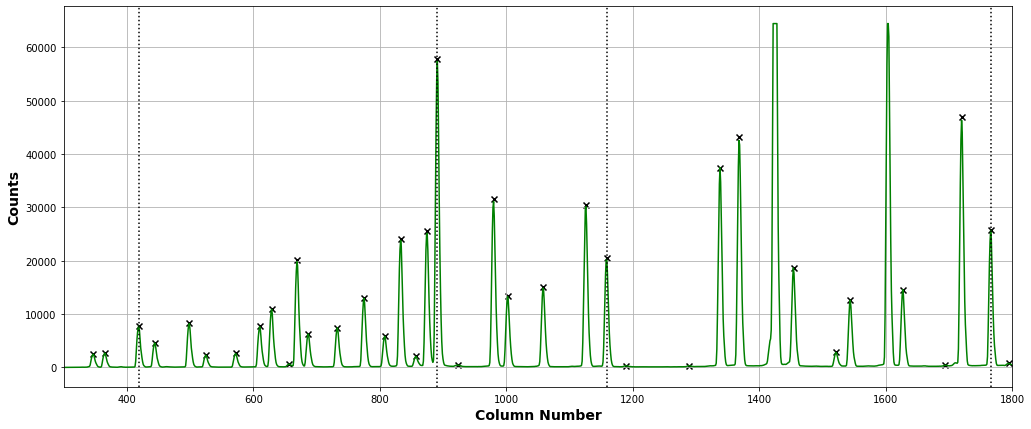

In [19]:
# find a section of lamp_spec that looks similar
col1 = 300
col2 = 1800
plt.plot(lamp_spec, c='g')
plt.xlim(col1, col2)
plt.xlabel('Column Number'); plt.ylabel('Counts'); plt.grid()

# mark lines with Gaussian-fit centers
mark_peaks(plt, lamp_lines)

# record the rough column numbers of the same lines as above in the same order
rough_cols = [410, 890, 1150, 1750]
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

When you have marked 3-4 matching lines, use the cells below to record the line wavelengths in `lamp_lines`.

In [20]:
def set_line_identity(lamp_lines, linelist, x, wav):
    # find the closest matching lamp_line
    ilamp = np.argmin(np.abs(lamp_lines['x'] - x))
    
    # find the closest matching row in the linelist
    ilist = np.argmin(np.abs(linelist['wav'] - wav))
    
    # reset values in lamp_lines
    lamp_lines[ilamp]['id'] = linelist[ilist]['id']
    lamp_lines[ilamp]['wav'] = linelist[ilist]['wav']

In [21]:
# record ids and wavelengths of matched lines
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)

## Set the initial wavelength solution

Using the matched column/wavelength pairs we can define an initial wavelength solution by assuming a polynomial (linear to start) relation.

In [22]:
# this routine finds the polynomial coefficients needed to transform between 
# column numbers and wavelengths (and vice versa). Outlier rejection is included.
def get_wavelength_solution(lamp_lines, order=4):
    wfit = np.isfinite(lamp_lines['wav'])
    
    # define the reverse mapping (wavelength to column)
    revcoeff = np.polyfit(lamp_lines['wav'][wfit], lamp_lines['x'][wfit], order)

    # define the forward mapping (column to wavelength)
    coeff = np.polyfit(lamp_lines['x'][wfit], lamp_lines['wav'][wfit], order)
    
    # check the fit for outliers
    fit_wav = np.polyval(coeff, lamp_lines['x'])
    wavres = fit_wav - lamp_lines['wav']
    lamp_lines['wavres'] = wavres
    sample = wavres[wfit]
    sample.sort()
    sample = sample[int(0.1 * sample.size) : int(0.9 * sample.size + 0.5)]    
    std = np.std(sample, ddof=1)
    w = wfit 
    w[wfit] = (np.abs(lamp_lines['wavres'][wfit]) < (5 * std))
    if w.sum() != lamp_lines.size:
        # re-fit with outliers rejected
        coeff, revcoeff = get_wavelength_solution(lamp_lines[w], order=order)
        
        # reset wavelength residuals using new coefficients
        fit_wav = np.polyval(coeff, lamp_lines['x'])
        wavres = fit_wav - lamp_lines['wav']
        lamp_lines['wavres'] = wavres
        
    lamp_lines['used'] = w
    return coeff, revcoeff
        
def check_wavelength_solution(lamp_spec, lamp_lines, coeff):    
    wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
    plt.plot(wavs, lamp_spec, c='g', lw=2)
    mark_peaks(plt, lamp_lines, 'wav')
    plt.colorbar(label='Residual ($\AA$)')
    plt.xlabel('Wavelength ($\AA$)')
    plt.ylabel('Counts')
    plt.grid()
    
def col_to_wav(coeff, cols):
    return np.polyval(coeff, cols)

def wav_to_col(revcoeff, wavs):
    return np.polyval(revcoeff, wavs)

def mark_matched(lamp_lines):
    for line in lamp_lines:
        plt.axvline(line['wav'], ls='dotted', c='k')

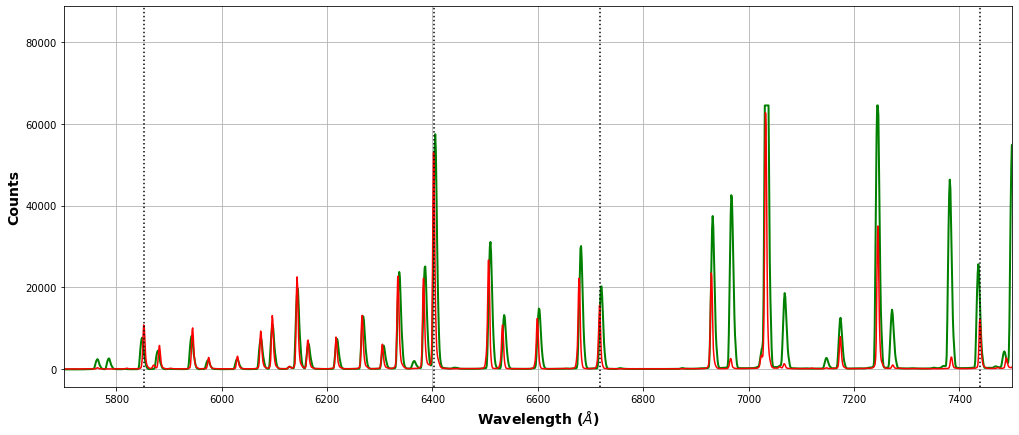

In [23]:
# estimate a linear relation between column number and wavlength
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=1)

# apply the wavelength solution to the column numbers
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))

# plot the initial wavelength calibrated spectrum
plt.plot(wavs, lamp_spec, c='g', lw=2, label='lamps')
plt.xlim(wav1, wav2)

# plot the reference spectrum in red
plt.plot(lamp_ref['wav'], lamp_ref['counts'], label='reference', c='r')
plt.xlim(wav1, wav2)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts'); plt.grid();
mark_matched(lamp_lines)

## Use the initial wavelength solution to match more lines

In [24]:
# check for more matches in the range already fit
def match_more(lamp_lines, linelist, order=4, tol=2):
    coeff, revcoeff = get_wavelength_solution(lamp_lines, order=order)
    wfit = np.isfinite(lamp_lines['wav'])
    minwav = lamp_lines['wav'][wfit].min()
    maxwav = lamp_lines['wav'][wfit].max()
    
    xmin = lamp_lines['x'][wfit].min()
    xmax = lamp_lines['x'][wfit].max()
    
    w = (lamp_lines['x'] > xmin) & (lamp_lines['x'] < xmax)
    for line in lamp_lines[w]:
        rough_wav = col_to_wav(coeff, line['x'])
        refwav = match_to_list(linelist['wav'], [rough_wav], tol=tol)
        if np.isfinite(refwav):
            #print(f'matched column {line["x"]:.1f} to wavelength {refwav[0]}')
            set_line_identity(lamp_lines, linelist, line['x'], refwav)
            
match_more(lamp_lines, linelist, order=1)

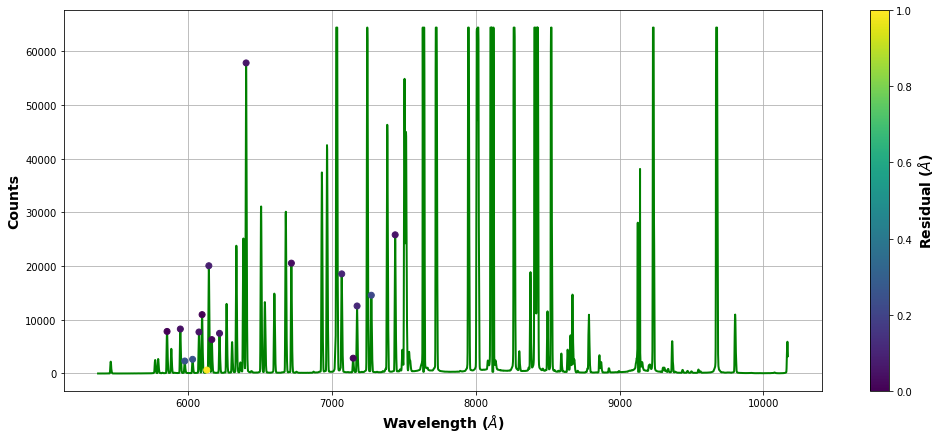

In [25]:
# re-fit with a higher order
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)
check_wavelength_solution(lamp_spec, lamp_lines, coeff)

## Use the revised wavelength solution to extend the range of matches

Pick lines near the ends of the spectra to extend the solution across the full wavelength range.

5460.7 is expected near column 77
9784.5 is expected near column 3705


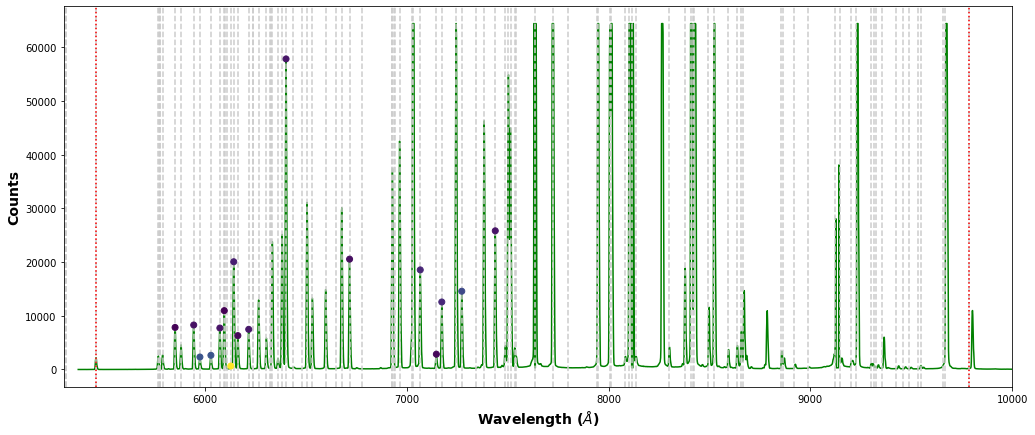

In [26]:
wav1 = 5300
wav2 = 10000

# plot line list over lamp spectra
wavs = col_to_wav(coeff, np.arange(lamp_spec.size))
plt.plot(wavs, lamp_spec, c='g')
plt.xlim(wav1, wav2)

# show available lines in the line list with dashed grey lines
for row in linelist:
    plt.axvline(row['wav'], ls='dashed', c='0.8')

# pick new lines to add
rough_waves = [5460, 9790] #[6960,  7170, 7440, 8380] # 7060, 7270, 
refwavs, rough_cols = match_to_list(linelist['wav'], rough_waves, plt=plt, revcoeff=revcoeff, c='r')
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)

# mark existing matches
mark_peaks(plt, lamp_lines, 'wav')
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts');

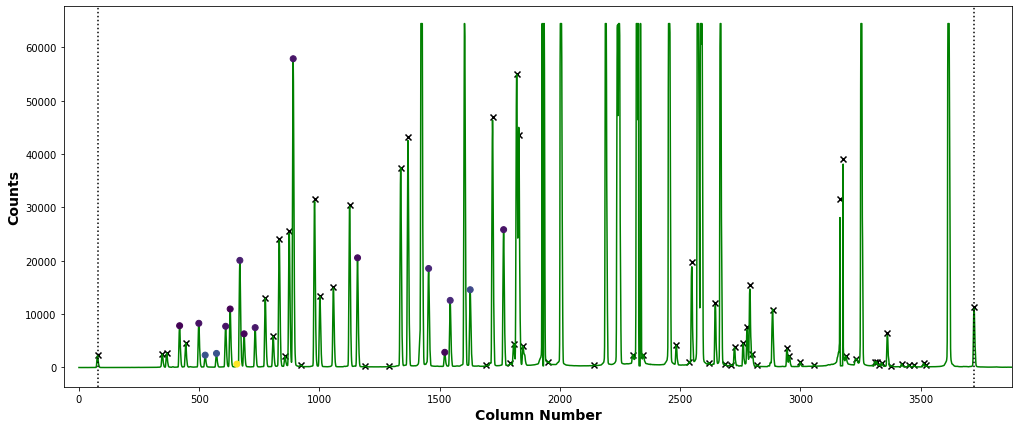

In [27]:
# check the supposed matches
col1, col2 = np.polyval(revcoeff, [wav1, wav2])
refcols = match_to_list(lamp_lines['x'], rough_cols)

plt.plot(lamp_spec, c='g')
mark_peaks(plt, lamp_lines, 'x', 'y')

plt.xlim(col1, col2)
refcols = match_to_list(lamp_lines['x'], rough_cols, plt=plt)
plt.xlabel('Column Number'); plt.ylabel('Counts');

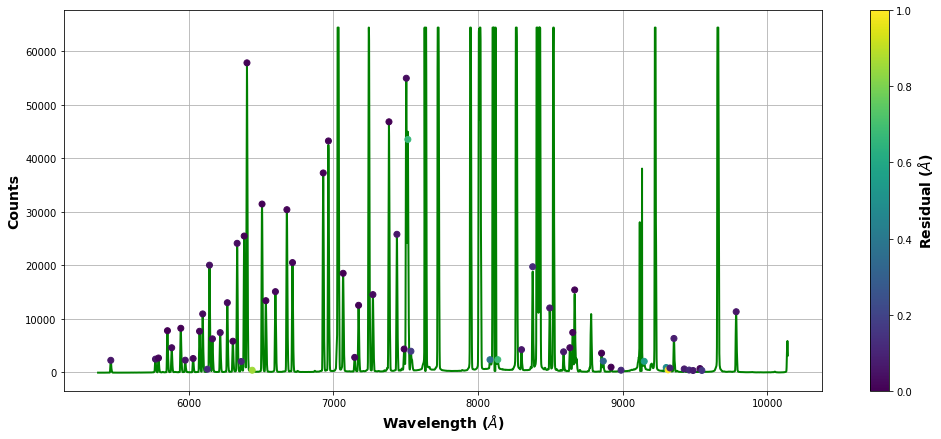

In [28]:
# add new lines to the matches
for col, wav in zip(refcols, refwavs):
    set_line_identity(lamp_lines, linelist, col, wav)
    
# auto-match more lines
match_more(lamp_lines, linelist)

# re-fit
coeff, revcoeff = get_wavelength_solution(lamp_lines, order=4)
check_wavelength_solution(lamp_spec, lamp_lines, coeff)

## Plot wavelength residuals

Make sure you have a good wavelength solution by checking the residuals. For the supplied Keck/LRIS data, the wavelength solution should be accurate to a fraction of an Angstrom.

STD of wavelength residual is 0.15 Angstrom


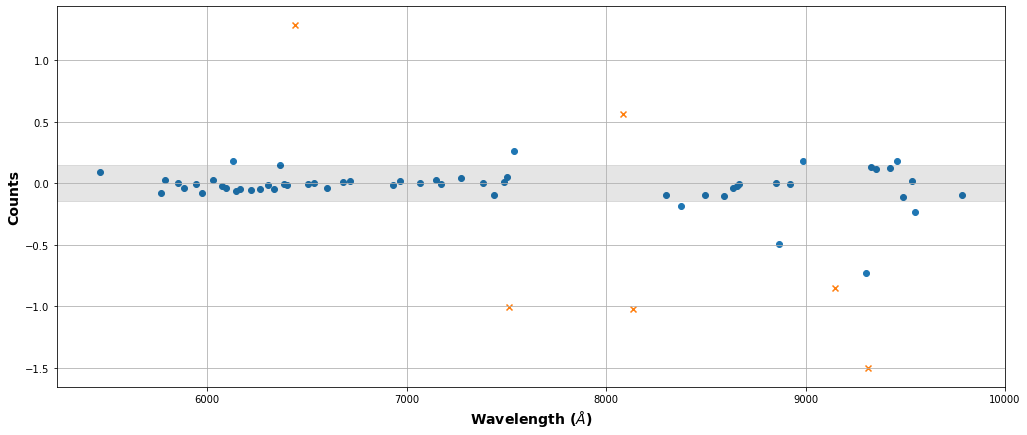

In [29]:
w = lamp_lines['used']
std = np.std(lamp_lines['wavres'][w], ddof=1)
print(f'STD of wavelength residual is {std:0.2} Angstrom')

plt.scatter(lamp_lines['wav'][w], lamp_lines['wavres'][w])
plt.scatter(lamp_lines['wav'][~w], lamp_lines['wavres'][~w], marker='x')
plt.axhspan(-std, std, color='k', alpha=0.1)
plt.xlabel('Wavelength ($\AA$)'); plt.ylabel('Counts'); plt.grid();

<a name="step2">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 2: Find the 2-D Wavelength Solution
    </h1>
</a>

With the 1-D wavelength solution now solved for the middle rows using the arc-lamp spectra, we can turn our attention to the science image. A typical deep exposure will be dominated by emission lines from the night sky. These can be much brighter than features in our science target, and, as with simple photometry, we must subtract the sky contribution from each spectral band we wish to measure. 

We can use spectra spatially offset from the target to define the pure background (just like photometry). The quick way to do this is to define a background aperture (a set of rows) offset from the target aperture to define the sky spectra, determine separate wavelength solutions for the background and target apertures, and then subtract the value of the sky background at every target wavelength. However, this is often imperfect because the background and target spectra will have different spectral bins so we must interpolate the background spectrum to the wavelengths of the target spectrum. There are trivial ways to do this, but these can perform poorly near bright sky lines.

Instead, we can use all the information available on the 2-D image to model the sky lines (see [Kelson 2003](https://ui.adsabs.harvard.edu/abs/2003PASP..115..688K/abstract)). Because lines of constant wavelength bend with row, each sky line is sampled in hundreds of different spectral bands. Using all of these (and excluding rows contaminated by target light, etc.) we can model the sky background as a function of wavelength on a fine scale and use this wealth of information to subtract the skylines from our target spectra. 

## Find the rows dominated by sky light (exclude rows with object light, bad rows)

To find the rows affected by the object traces, we can just marginalize over all the columns to determine the average profile and then note where this is significantly above the background average.

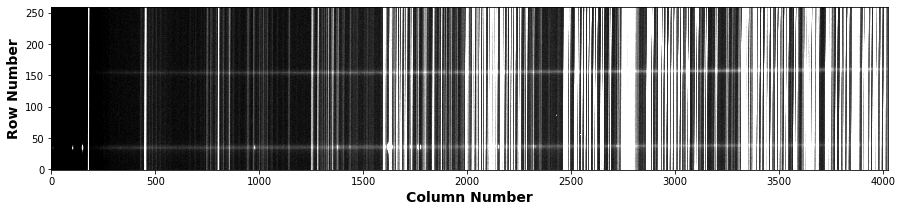

In [30]:
# display the science image
show_image(image)

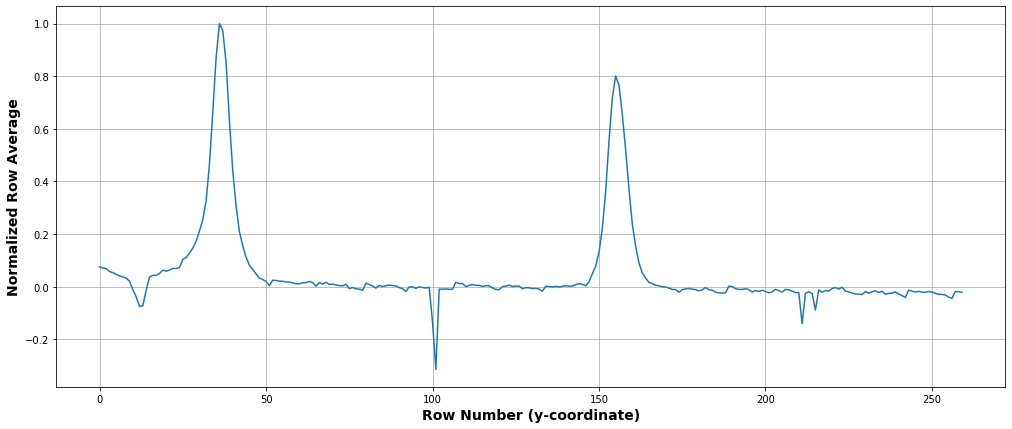

In [31]:
# compute the row averages and normalize so that the background is near 0 and the peaks are near 1
rowaverage = image.mean(axis=1)
rowaverage -= np.median(rowaverage)
rowaverage /= rowaverage.max()
plt.plot(ys, rowaverage)
plt.xlabel('Row Number (y-coordinate)'), plt.ylabel('Normalized Row Average')
plt.grid();

#### Notes
* the plot above should show peaks in the rows containing object light
* you may also notice a few bad rows (actually bad columns!) with counts significantly below the median.

Based on the plot above, record the row coordinates (`ys`) that are brighter that some threshold, say 20% of the profile peak. To be conservative, also include the 5 rows above and 5 rows below.

Then create a 2D boolean mask that is `True` for pixels that are dominated by sky light and `False` for other pixels.

In [32]:
# find the rows with object light
objrows = ys[rowaverage > 0.2]

# add some margin to object rows
ngrow = 5 # number of rows to include above and below object rows
newobjrows = []
for row in objrows:
    newobjrows.extend([row + i for i in np.arange(-ngrow, ngrow + 1)])
objrows = np.unique(newobjrows)

# mask to mark sky rows
skymask = np.ones(image.shape, dtype=bool)
skymask[objrows, :] = False

# also exclude bad rows
badrows = ys[rowaverage < -0.05]
skymask[badrows, :] = False

# rows with mostly sky background light
skyrows = ys[skymask.mean(axis=1) == 1]

With the object traces and bad rows masked, we can also check for cosmic rays and mask these as well. To do this we calculate the median value and standard deviation along each column and then reject pixels that are more than a certain number (typically 3-5) of standard deviations away from the median. These deviant pixels are then noted on the `skymask`.

In [33]:
# median (unmasked) sky spectrum and standard deviation
medspec = np.median(image[skyrows, :], axis=0)
stdspec = np.std(image[skyrows, :], axis=0, ddof=1)

# exclude deviant pixels from the skymask
pull = (image - medspec) / stdspec
w = pull > 5
skymask[w] = False

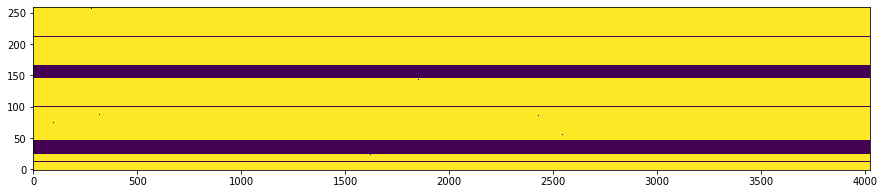

In [34]:
# show the mask
plt.figure(figsize=(15, 3))
plt.imshow(skymask, origin='lower', aspect='auto');

## Look at a small section of image up close

In [35]:
# cut out a small image "stamp" near the center of the frame
row = cy
col = cx
hwidth = 50
stamp = image[:, col - hwidth : col + hwidth]
ys_stamp = yvals[:, col - hwidth : col + hwidth]
xs_stamp = xvals[:, col - hwidth : col + hwidth]

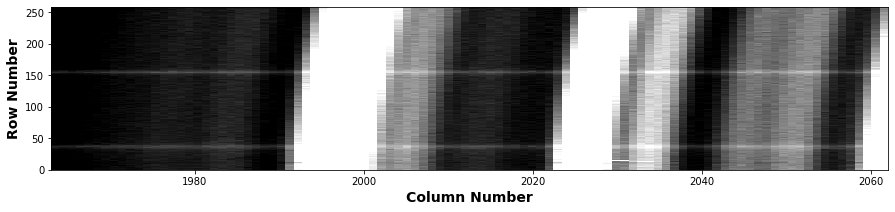

In [36]:
# show the image stamp
extent = (xs_stamp.min(), xs_stamp.max(), ys_stamp.min(), ys_stamp.max())
show_image(stamp, extent=extent);

Recall the vertical bands are sky lines that mark lines of constant wavelength. Notice that these do not run perfectly parallel to the columns. Rather, the `x` coordinate for a given wavelength will be a function of the row number. 

As the plot should demonstrate, the lines of constant wavelength are slightly tilted with respect to the columns and there is also slight curvature. Thus we can approximate that the `x` coordinate for a given wavelength will be a quadratic function of the row number.

#### Note
Because wavelength varies along a given column, if we simply plot the counts in each pixel against each pixel's column number then we get a range of values in each column:

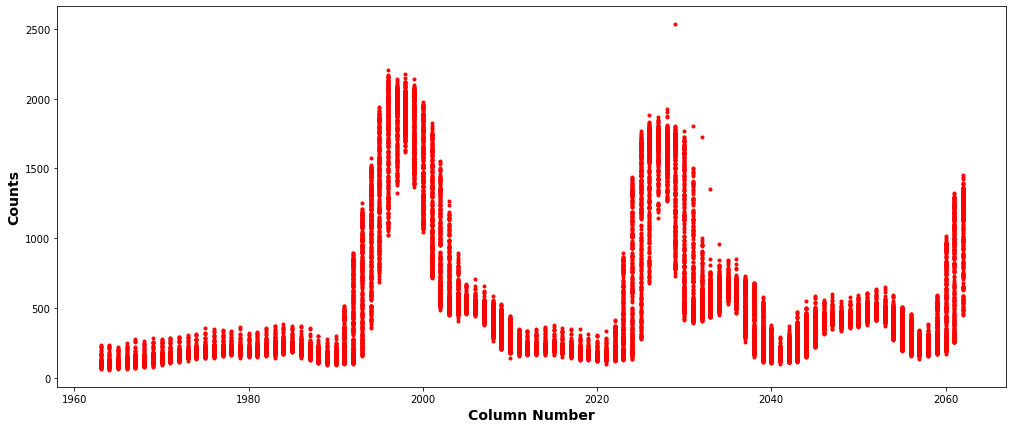

In [37]:
# plot stamp values against column numbers
plt.plot(xs_stamp.ravel(), stamp.ravel(), 'r.');
plt.xlabel('Column Number'), plt.ylabel('Counts');

## Map out lines of constant wavelength (determine the wavelength for each pixel)

We can model the change in wavelength coordinate in arbitrary units, `dl`, from the wavelength at some reference pixel in terms of the offsets, `dx` and `dy` from the reference pixel.

We can then write down a function that takes our model parameters (the slope and curvature of the lines of constant wavelength with respect to the columns), the offsets in the x and y coordinates, `dxs` and `dys`, respectively, and returns the wavelength offset from the reference pixel (i.e. `dx = dy = 0`).

In [38]:
def get_dl_model(params, dxs, dys):
    return dxs + params[0] * dys + params[1] * dys ** 2

To see how this works, make a guess for the slope and curvature parameters and try plotting the wavelength offsets from our reference pixel (the one at `x=col` and `y=row`).

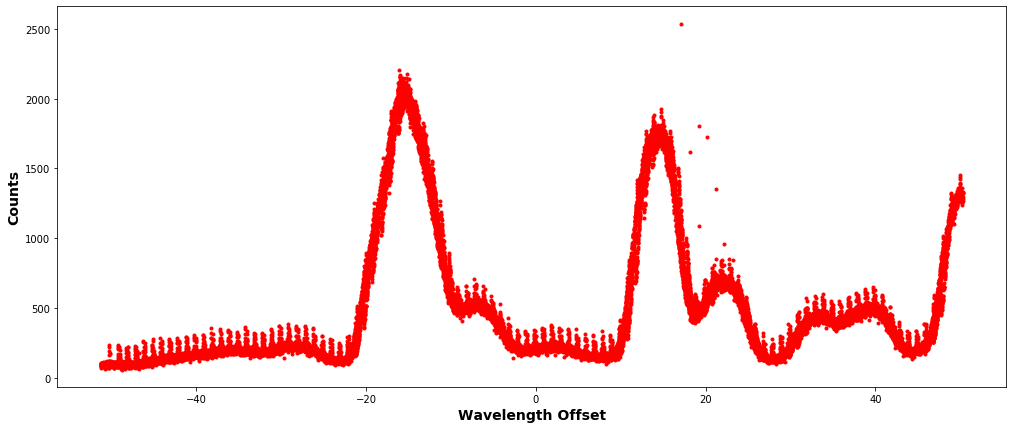

In [39]:
# pixel offsets from the refernece pixel
dxs = xs_stamp - col
dys = ys_stamp - row

# parameter guess
guess = (-0.01, 0)

# get the wavelength offsets and plot vs. counts
dls = get_dl_model(guess, dxs, dys)
plt.plot(dls.ravel(), stamp.ravel(), 'r.')
plt.xlabel('Wavelength Offset')
plt.ylabel('Counts');

You should notice that for the right choice of model parameters, the vertical scatter is significantly reduced. This demonstrates one way to decide on the best model parameters: find the model parameters that minimize the vertical scatter. But how do we measure this scatter?

## Fit a spline to the counts spectrum above

Given the data above (the wavelength offsets, `dls`, and the stamp count values) we can fit a spline to the resulting curve above and then subtract this off from the curve and measure the scatter. Notice that for every column we get a lot of samples (`ny` to be precise). Thus we can set the spline knots every pixel (or even closer).

We can define a function that will return the best fit spline object (in the least-squares sense) for our data.

In [40]:
def get_profile_spl(dls, stamp):
    # need to sort the data (and weights) so that the x values are increasing
    x, y = dls.ravel(), stamp.ravel()
    weights = np.sqrt(np.abs(y)) # not technically optimal for coadded data, but ok
    wsort = x.argsort()
    x, y, weights = x[wsort], y[wsort], weights[wsort]

    # set locations for spline knots
    t = np.linspace(x.min() + 1, x.max() - 1, np.int(x.max() - x.min()))
    spl = LSQUnivariateSpline(x, y, t, weights)
    return x, y, spl

Lets see how good this looks.

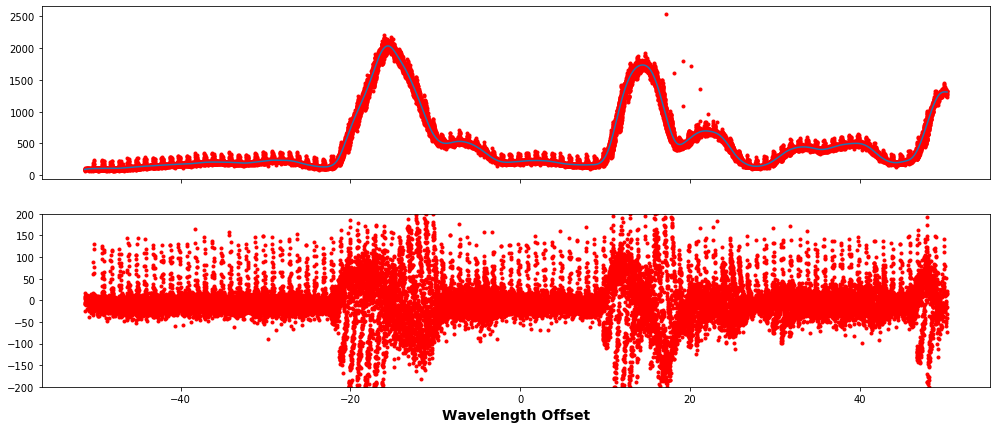

In [41]:
# fit a spline to the data and plot
x, y, spl = get_profile_spl(dls, stamp)

fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(x, y, 'r.')
axarr[0].plot(x, spl(x))
axarr[1].plot(x, y - spl(x), 'r.')
plt.ylim(-200, 200)
plt.xlabel('Wavelength Offset');

#### Notice
 * the counts may vary along the slit (both because of real spatial variations and, more importantly, we have not accounted for efficiency variations along the slit), so there may be some biased scatter
 * the parameter guess above may be imperfect resulting in systematic residuals (we can minimize these below)

## Minimize residuals from the spline model to determine the best tilt/curvature model

We need a metric to determine how well the spline fits the data. We could take a simple sum of the squares of the residuals or weight these by the expected poison noise to determine a $\chi^2$ value.

In [42]:
def check_dl_model(params, dxs, dys, stamp):
    dls = get_dl_model(params, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    chisq = np.sum((stamp - spl(dls)) ** 2 / np.sqrt(np.abs(stamp)))
    return chisq / (stamp.size - len(params))

In [43]:
# see how good our guess is
check_dl_model(guess, dxs, dys, stamp)

115.56365736334747

Now we just need to change the model parameters to minimize the residuals. We can use `fmin` for this.

In [44]:
# get the best model parameters for this stamp
params = fmin(check_dl_model, guess, args=(dxs, dys, stamp))
print("best model parameters are", params)

Optimization terminated successfully.
         Current function value: 50.174574
         Iterations: 27
         Function evaluations: 54
best model parameters are [-1.30240870e-02 -2.58517988e-05]


You can plug in these parameters for your `guess` above and re-run the cells to check the residuals if you want.

## Find the lines of constant wavelength at other parts of the 2-D image

The tilt/curvature between lines of constant wavelength and the columns can vary across the spectrum. So far we have only determined it for a small portion of the image. Now we can apply the same techniques to map out the relative wavelengths shifts across the image.

To do this, we need to pick a width (number of columns) within which we can expect to get enough sky lines to do the mapping. Considering the left side (shorter wavelength or "blue" portion) of the spectrum, we can set the width at about 400 columns. (Note it is possible to vary the width across the image to take advantage of the extra wavelength information in the near-IR, but this is not required).

In [45]:
# define the column centers for the stamps
hwidth = 200
cols = np.arange(hwidth, nx, 2 * hwidth)
cols

array([ 200,  600, 1000, 1400, 1800, 2200, 2600, 3000, 3400, 3800])

As above, map out the wavelength shits along columns, one stamp (image section) at a time. It is best to use the sky mask we defined above and possibly some outlier rejection to fend off deviant pixels.

Notice that the code cell below will keep track of the wavelength offsets for all columns, but really we only need the central columns defined above.

In [46]:
# reference wavelength offsets to the center row
row = cy

# define a 2D array to hold the wavelength offsets for each pixel
lambdas = np.zeros(image.shape) 

# loop over each central column
for col in cols:
    print('col = ', col)
    
    # slice the data
    inds = np.s_[:, col - hwidth : col + hwidth]
    stamp = image[inds]
    mask = skymask[inds]
    dys = yvals[inds] - row
    dxs = xvals[inds] - col

    # initial fit
    params = fmin(check_dl_model, guess, args=(dxs[mask], dys[mask], stamp[mask]))
    
    # check for outliers
    dls = get_dl_model(guess, dxs, dys)
    x, y, spl = get_profile_spl(dls, stamp)
    model = spl(dls)
    pull = (stamp - model) / np.sqrt(np.abs(model))
    w = (pull < 5) & mask
    params2 = fmin(check_dl_model, params, args=(dxs[w], dys[w], stamp[w]))

    # record
    lambdas[inds] = get_dl_model(params2, dxs, dys) + col


col =  200
Optimization terminated successfully.
         Current function value: 12.460472
         Iterations: 25
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 12.985240
         Iterations: 8
         Function evaluations: 16
col =  600
Optimization terminated successfully.
         Current function value: 8.974731
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 8.974149
         Iterations: 6
         Function evaluations: 13
col =  1000
Optimization terminated successfully.
         Current function value: 8.949836
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 8.949836
         Iterations: 8
         Function evaluations: 15
col =  1400
Optimization terminated successfully.
         Current function value: 9.830064
         Iterations: 20
         Function evalu

Look at a few rows and see how the wavelength offsets vary with column number. We can fit a low-order polynomial to these.

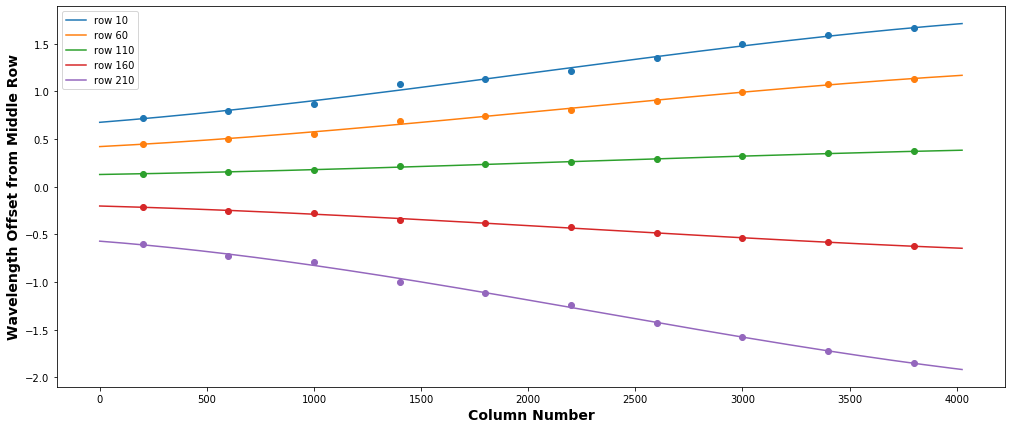

In [47]:
# just plot offsets for a few of the rows across the image
order = 3
for y in range(10, ny, 50):
    p = plt.plot(cols, lambdas[y, cols] - xs[cols], 'o')
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    plt.plot(xs, np.polyval(c, xs), c=p[0].get_color(), label='row {}'.format(y))
plt.legend()
plt.xlabel('Column Number')
plt.ylabel('Wavelength Offset from Middle Row');

You may notice that the tilt (the wavelength difference in a given column between the first row and the last row) increases as we move to larger column numbers. Make sure the order is large enough to follow the trends without over fitting the data (i.e. there should not be noticeable wiggles between data points).

Now we can fit for every row. We could do a 2D fit to all the data at once, but simply fitting row by row works here.

In [48]:
# get the lambda values for the entire image (fit)
lambdafit = np.zeros(image.shape)
for y in range(ny):
    c = np.polyfit(cols, lambdas[y, cols] - xs[cols], order)
    lambdafit[y, :] = np.polyval(c, xs) + xs

Now for the fun part! We have wavelength values relative to the central row (in arbitrary units) for every pixel on the image, which means we can do some cool tricks.

<a name="step3">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 3: Flat Field the 2D Spectra (Optional)
    </h1>
</a>

To this point we have not corrected the data for pixel-to-pixel efficiencies (in other words, we have not flat-fielded the data). For many tasks this is actually not required, but if you have *good* flat field exposures available, flat fielding can improve the output data quality.

The key for spectroscopy is to note that the CCD response is wavelength dependent (you wouldn't use a U-band flat to process an I-band image, right?), and with spectra there are many wavelength bins to account for. Just as with photometry, we do not care so much how many counts we get in a given wavelength bin, we can just determine the average number in each wavelength bin and then divide by this average to get numbers close to 1.

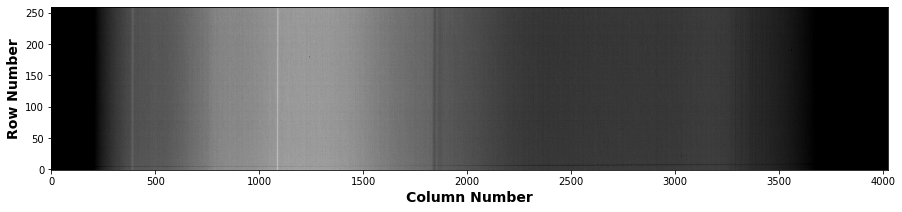

In [49]:
# load in the flat
flat = fits.getdata(os.path.join(data_dir, 'spec_flat.fits'))
show_image(flat)

Notice that the average counts vary considerably with wavelength and there are even a few line features present in the data (there is air between the light source and the camera, and air can emit and absorb light!).

Since we know the wavelengths for each pixel, this is no problem. We can fit a spline to this profile (which is marginalized over slit position) to determine the typical number of counts in each wavelength bin and then divide each pixel by the appropriate value from the spline fit to normalize the counts.

In [50]:
# fit a spline
x = lambdafit.ravel()
y = flat.ravel()
weights = np.sqrt(np.abs(y)) 
wsort = x.argsort()
x, y, weights = x[wsort], y[wsort], weights[wsort]
t = np.linspace(x.min() + 1, x.max() - 1, nx)
spl = LSQUnivariateSpline(x, y, t, weights)

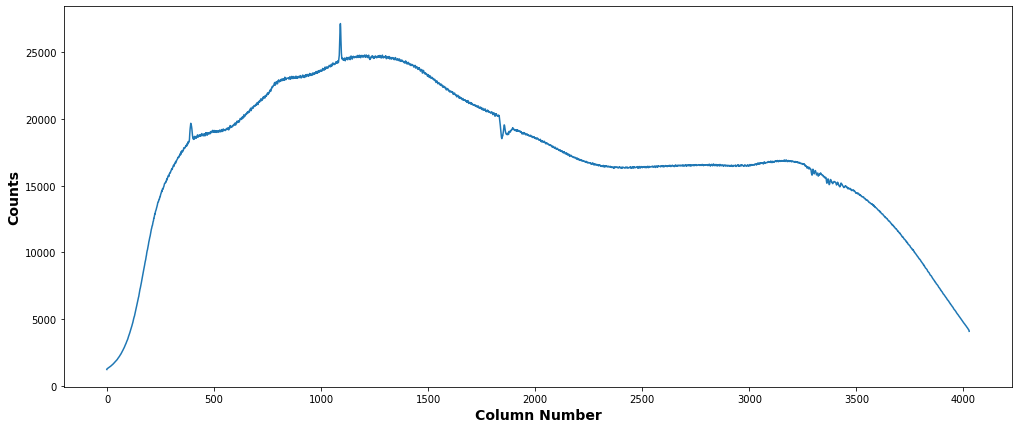

In [51]:
# plot the spline
plt.plot(x, spl(x))
plt.xlabel('Column Number')
plt.ylabel('Counts');

In [52]:
# normalize the flat field 
normflat = flat / spl(lambdafit)

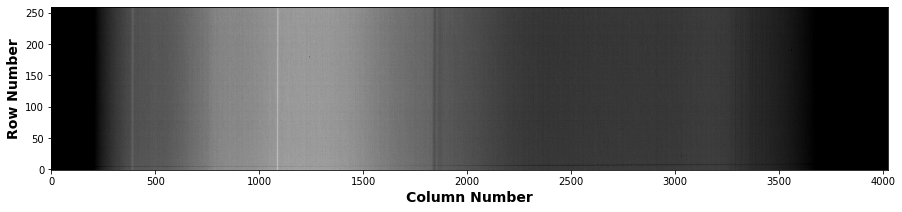

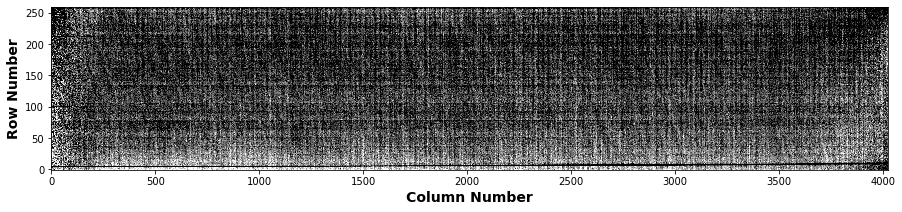

In [53]:
show_image(flat)
show_image(normflat)

You can now divide the science images by this normalized flat to correct for pixel-to-pixel differences.

In [54]:
# flat field the 2D science image using the normalized flat
image /= normflat

<a name="step4">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 4: Model the 2D Sky
    </h1>
</a>

We want to measure the light from our target, not the night sky, so lets make those sky lines disappear! We can do a 2-D spline fit to the sky background pixels to create a sky model. As above, we have about `ny` measurements in each wavelength bin, so we can set the knot points along the wavelength direction about every pixel (or even less!). We do not expect strong variations in the sky brightness along the slit, so we can simply fit a low order polynomial along this direction (which we will approximate for now using the y-coordinates).

In [55]:
# function to fit a 2D spline
def fit_sky(xvals, yvals, image, ky=1, dx=0.5):
    # select knot points in the x (wavelength) direction
    tx = np.arange(xvals.min() + 2, xvals.max() - 2, dx)
    
    # select knot points in the y (spatial) direction
    ty = [] # if there are no knots, the fit will be a poly nomial of degree ky
    
    # fit the 2D spline
    return LSQBivariateSpline(xvals.ravel(), yvals.ravel(), image.ravel(), tx, ty, ky=ky)

In [56]:
# use the (unmasked) sky background pixels and fit the 2D spline
skyfit = fit_sky(lambdafit[skymask], yvals[skymask], image[skymask])

# evaluate the 2D sky at every pixel
sky = skyfit.ev(lambdafit, yvals)

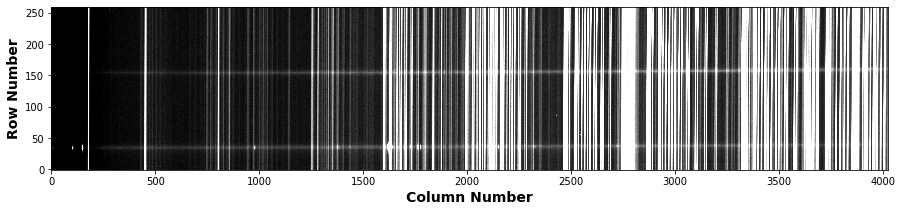

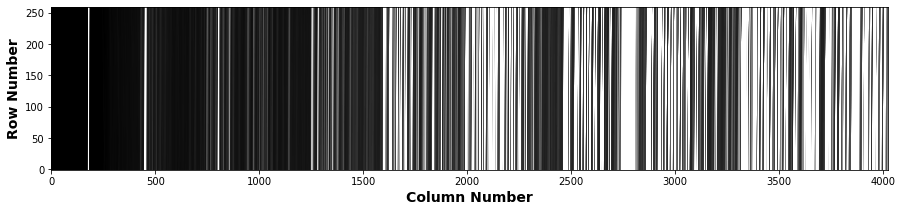

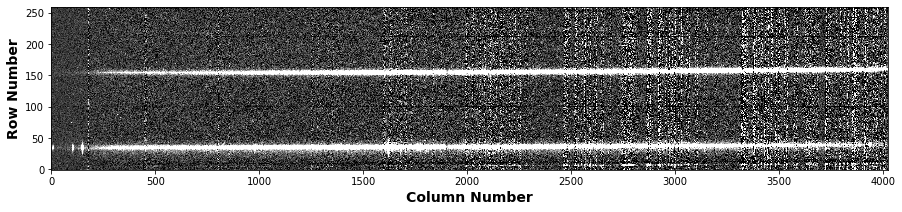

In [57]:
show_image(image)
show_image(sky)
show_image(image-sky)

Notice how well the object trace stands out now. Analogous to the sky lines, the object trace is slightly tilted with respect to the rows. Thus to extract our spectrum we need to map out the y-values where the trace is centered as a function of column number.

<a name="step5">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 5: Extract the 1-D Target Spectrum
    </h1>
</a>

We can sum the counts in the sky subtracted image above to create a counts spectrum of our target. As with photometry we need to define an aperture (or a construct a probability map) to mark which pixels contain target light so that we can reject neighboring objects. 

## Locate object trace

There are actually two object traces in the supplied Keck/LRIS data, so let's simultaneously find the centers of each of these. The object that makes the lower trace is actually a galaxy, but we can approximate its distribution of light along the slit with a Gaussian function, and we can do the same for the other object. Thus our profile model will be the sum of two Gaussians. 

In [58]:
def get_profile_model(params, ys):
    a1, cy1, sigma1, a2, cy2, sigma2 = params
    
    p1 = np.exp(-(ys - cy1)**2 / 2 / sigma1**2) 
    p1 /= p1.max()
    
    p2 = np.exp(-(ys - cy2)**2 / 2 / sigma2**2) 
    p2 /= p2.max()

    return a1 * p1 + a2 * p2

Now that we have our model, we can make a guess at the parameters and check by eye how well these represent the data. Change the guess until the model is a reasonably close match to the data (this need not be perfect).

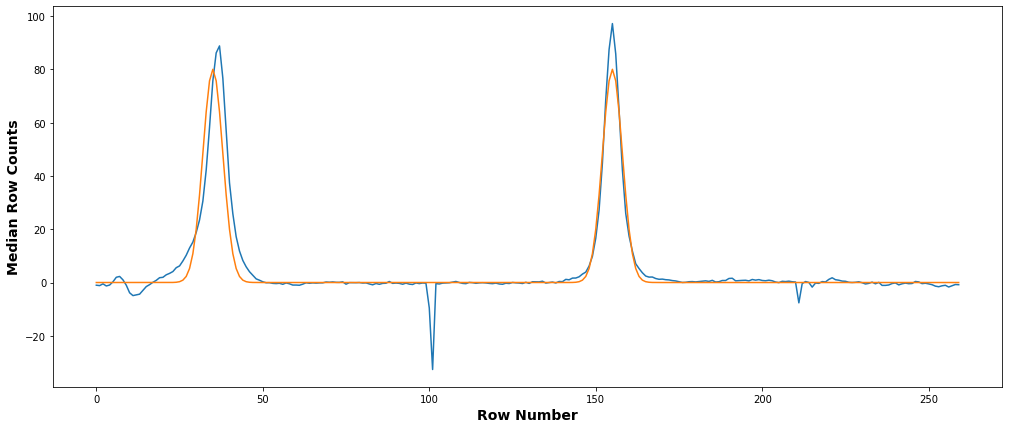

In [59]:
# get the median for each row
profile = np.median(image - sky, axis=1)

# starting guess for the profile model
guess = (80, 35, 3, 80, 155, 3)
model = get_profile_model(guess, ys)

plt.plot(ys, profile)
plt.plot(ys, model);
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts');

Of course, we can improve the model by minimizing the model residuals (or $\chi^2$/dof).

In [60]:
def get_profile_chisq(params, ys, profile):
    model = get_profile_model(params, ys)
    return np.sum( (profile - model)**2 / np.sqrt(np.abs(profile)) ) / (profile.size - len(params))

Optimization terminated successfully.
         Current function value: 2.529312
         Iterations: 307
         Function evaluations: 495
best fit parameters are [ 79.16951747  36.25870806   3.46038831  89.8573188  154.96099859
   2.70733517]


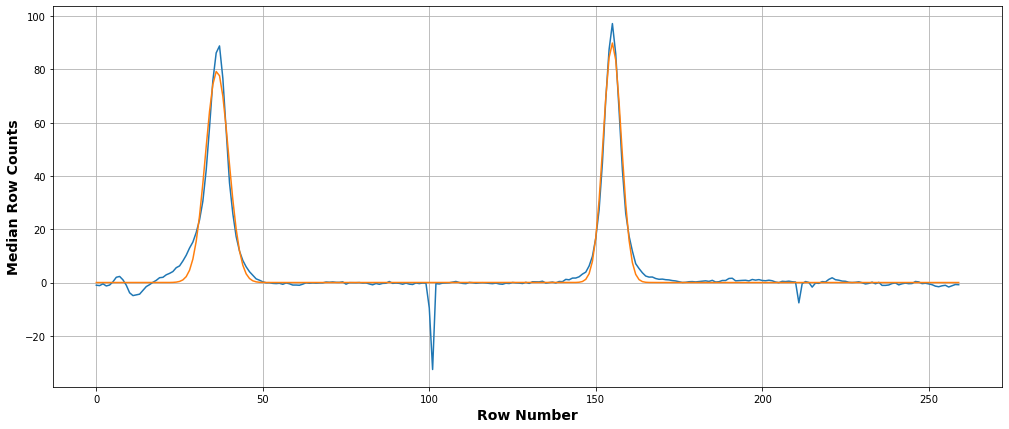

In [61]:
# fit for the best model
params = fmin(get_profile_chisq, guess, args=(ys, profile))
print("best fit parameters are", params)

model = get_profile_model(params, ys)
plt.plot(ys, profile)
plt.plot(ys, model)
plt.xlabel('Row Number')
plt.ylabel('Median Row Counts')
plt.grid();

We could fit a more complex model that accounts for the vertical shift of the traces with column numbers, but here we simply divide the image up into sections by wavelength and find the Gaussian centroids in each of these.

In [62]:
# fit the profile centered at these columns
hwidth = 50
cols = np.arange(hwidth, nx + 1, 2 * hwidth)

ycenter = np.zeros( (len(cols), 2) )
for icol, col in enumerate(cols):
    stamp = (image - sky)[:, col - hwidth : col + hwidth]
    profile = np.mean(stamp, axis=1)
    params = fmin(get_profile_chisq, guess, args=(ys, profile))
    ycenter[icol, :] = params[[1, 4]]

Optimization terminated successfully.
         Current function value: 0.367322
         Iterations: 500
         Function evaluations: 792
Optimization terminated successfully.
         Current function value: 1.700793
         Iterations: 744
         Function evaluations: 1165
Optimization terminated successfully.
         Current function value: 1.234982
         Iterations: 373
         Function evaluations: 589
Optimization terminated successfully.
         Current function value: 1.788430
         Iterations: 319
         Function evaluations: 507


/Users/rquimby/miniconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Optimization terminated successfully.
         Current function value: 3.196958
         Iterations: 312
         Function evaluations: 511
Optimization terminated successfully.
         Current function value: 2.523173
         Iterations: 333
         Function evaluations: 522
Optimization terminated successfully.
         Current function value: 2.492250
         Iterations: 411
         Function evaluations: 641
Optimization terminated successfully.
         Current function value: 2.796160
         Iterations: 241
         Function evaluations: 395
Optimization terminated successfully.
         Current function value: 3.513546
         Iterations: 284
         Function evaluations: 461
Optimization terminated successfully.
         Current function value: 3.351843
         Iterations: 335
         Function evaluations: 523
Optimization terminated successfully.
         Current function value: 3.292683
         Iterations: 260
         Function evaluations: 428
Optimization termina

Lets see how the y-center of our target's trace varies with column number. We can fit a polynomial to the trend and use this to estimate the y-center at any column.

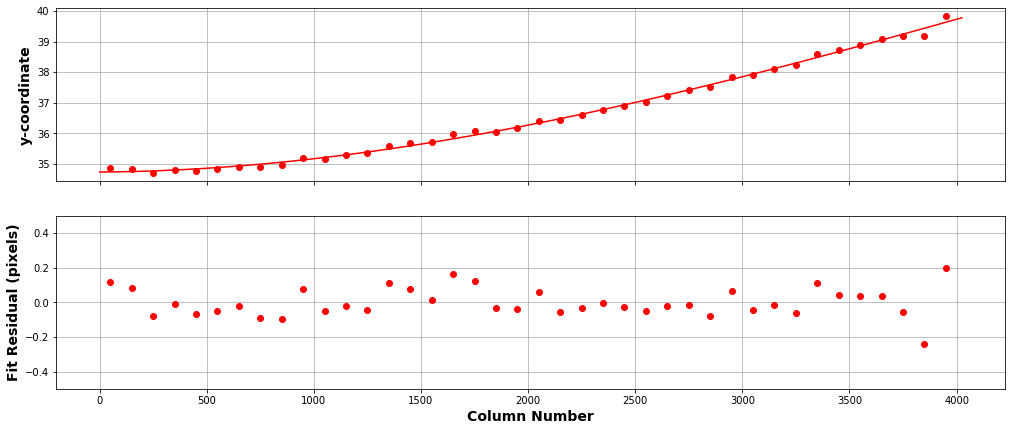

In [63]:
# fit the relation with a polynomial
ind = 0 # which trace 0 or 1?
t_order = 3
trace_c = np.polyfit(cols, ycenter[:, ind], t_order)
fig, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(cols, ycenter[:, ind], 'ro')
axarr[0].plot(xs, np.polyval(trace_c, xs), 'r')
axarr[0].axes.set_ylabel('y-coordinate'); axarr[0].grid();
axarr[1].plot(cols, ycenter[:, ind] - np.polyval(trace_c, cols), 'ro')
axarr[1].axes.set_ylim(-0.5, 0.5)
axarr[1].axes.set_ylabel('Fit Residual (pixels)')
plt.xlabel('Column Number'); axarr[1].grid();

The typical residuals should be a small fraction of a pixel. 

**Note** we are fitting a Gaussian model to a non-Gaussian (galaxy) profile, so the center value may be systematically offset.

Now we can get the pixel offsets from the object trace for every pixel in the image. To properly account for non-linearities along the trace (i.e. the pixel scale may be 0.1 arcsec per y-pixel on the blue side but 0.12 arcsec per pixel on the red side) we could use the second object trace and the relative wavelength information, but here we will simply assume a simple linear relation.

In [64]:
# position offsets from the object trace (defined to be at slitpos = 0)
slitpos = yvals - np.polyval(trace_c, yvals)

## Spatial profile of the target

Next, determine the spatial profile of the target and stretch this over the whole 2D image to make a weight map for later use.

The brightness of the target will vary as a function of wavelength, so to determine the profile we can normalize the counts in each wavelength bin using the counts at the trace center (or our approximation there of).

In [65]:
# subtract the sky
nosky = image - sky

# normalize to the pixel brightness at the trace center
yinds = (np.round(np.polyval(trace_c, xs))).astype(int)
normed = nosky / nosky[yinds, xs]

Fit a spline to the normalized profile

In [66]:
# get 1D arrays with the positions along the slit and the normalized counts
pos = slitpos.flatten()
counts = normed.flatten()

# sort by slit position
sort_inds = pos.argsort()
pos, counts = pos[sort_inds], counts[sort_inds]

# fit a spline to model the spatial profile
t = np.linspace(pos.min() + 2, pos.max() - 2, ny // 2) # spline knot points
profile_spl = LSQUnivariateSpline(pos, counts, t)

# remove outliers and re-fit
diff = counts - profile_spl(pos)
sample = sigma_clip(diff)
w = ((np.abs(diff) / sample.std()) < 5) & np.isfinite(diff)
profile_spl = LSQUnivariateSpline(pos[w], counts[w], t)

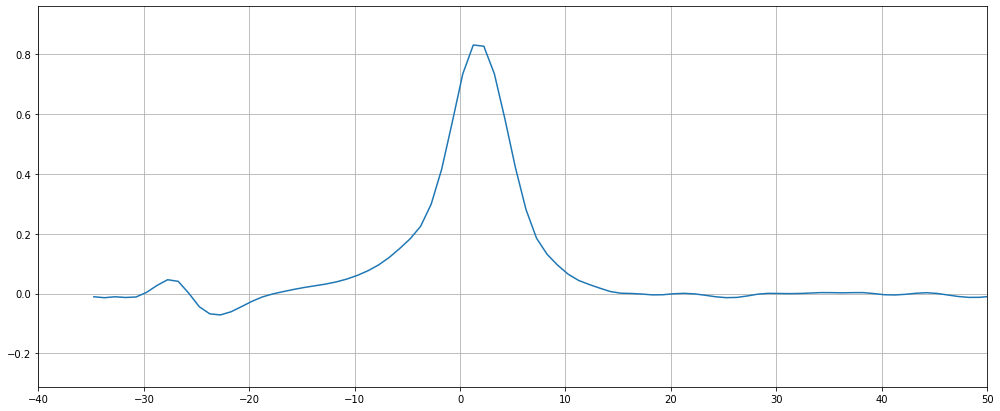

In [67]:
# plot the target profile
plt.plot(pos, profile_spl(pos) )
plt.xlim(-40, 50)
plt.grid();

Calculate the profile for every column to make a 2D profile image.

In [68]:
# create the profile image
profile_image = profile_spl(slitpos)

# de-weight negative values in provile_image
profile_image[profile_image < 0] = 0

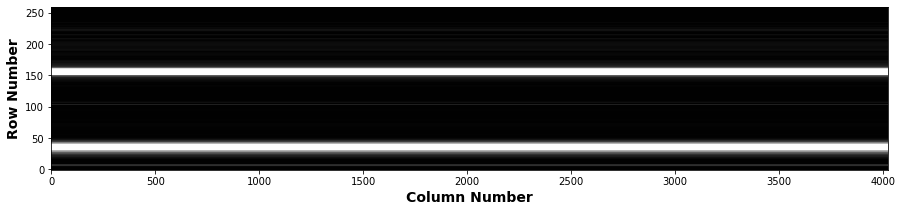

In [69]:
show_image(profile_image, upper=50)

## Extract the target spectrum (basic version)

We have located the target trace, the sky background has been removed, so all that is left to do is sum up the counts in each wavelength bin in some aperture. We can pick any size wavelength bin we like, but at this phase it is common to use the native pixel scale to set the binning. If the target extends over many pixels in the spatial direction or the tilt/curvature of the lines of constant wavelength is large, you may have to take into account the changes in wavelength with row number. But for the supplied data the change in wavelength is not significant along the short extraction window, so we can simply sum along columns.

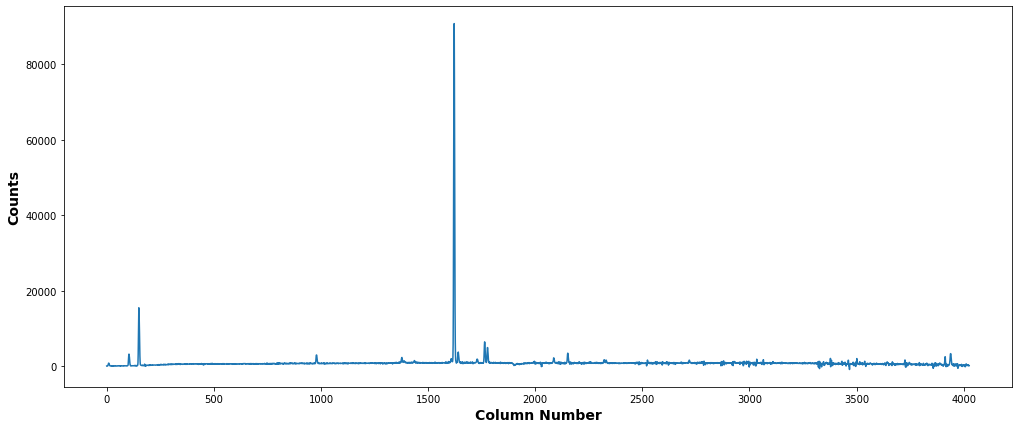

In [70]:
# select which rows to sum
w = (slitpos > -10) & (slitpos < 10)
ymin, ymax = yvals[w].min(), yvals[w].max()

# calculate the sum
spec_basic = nosky[ymin:ymax, :].sum(axis=0)

# sky background
skybg_basic = sky[ymin:ymax, :].sum(axis=0)

# plot the extracted spectrum
plt.plot(xs, spec_basic)
plt.xlabel('Column Number')
plt.ylabel('Counts');

## Optimal extraction

Analogous to PSF-fitting in 2D image data, we can weight the extraction using the spatial profile we calculated above to limit the noise from pixels that are dominated by the sky background. Instead of fitting a model to the data however, we will simply calculate a weighted average in each wavelength bin. Using our basic extraction above we can determine the bias between the sum and the weighted average and then use this to re-scale the weighted average, because ultimately we want the sum of the counts from the target, not the average in each wavelength bin.

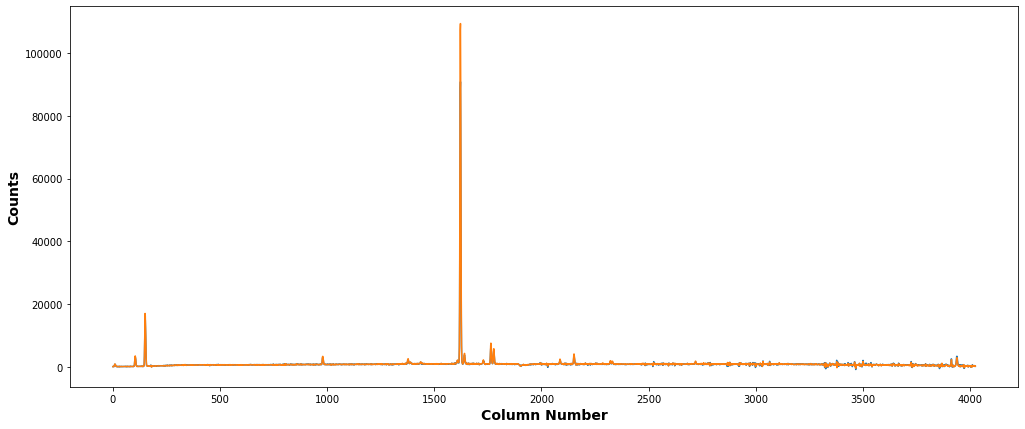

In [71]:
# calculate the weighted average (for each column)
spec_opt = (nosky * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)

# calculate the bias factor needed to scale the average to a sum
bias_factor = np.median(spec_basic / spec_opt)
spec_opt *= bias_factor

# same for the sky background
skybg_opt = (sky * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor_sky = np.median(skybg_basic / skybg_opt)
skybg_opt *= bias_factor_sky

# plot the extracted spectrum
plt.plot(xs, spec_basic, label='basic extraction')
plt.plot(xs, spec_opt, label='optimal extraction')
plt.xlabel('Column Number')
plt.ylabel('Counts');

If you look closely you should see that the basic extraction is noisier than the optimal.

<a name="step6">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 6: Tweak the Wavelength Solution Using Sky Lines
    </h1>
</a>

Spectrographs, including Keck/LRIS, may warp slightly as the telescope they are mounted to moves across the sky, and this can result in wavelength drift (the wavelength of a given pixel may change over time). Thus the wavelength solution we derived using the arc-lamp spectra may not apply exactly to our science data. One remedy for this is to use the wavelengths of sky lines to correct for spectral drift.

## Start with the wavelength solution from the arc-lamps using the target aperture

In [72]:
# re-extract lamp spectra using the profile_image
lamp_basic = lamp_image[ymin:ymax, :].mean(axis=0)
lamp_spec_opt = (lamp_image * profile_image)[ymin:ymax, :].sum(axis=0) / profile_image.sum(axis=0)
bias_factor = np.median(lamp_basic / lamp_spec_opt)
lamp_spec_opt *= bias_factor

# re-compute lamp_lines
lamp_lines_opt = get_lamp_lines(lamp_spec_opt)

found center pixel values for 83 lines


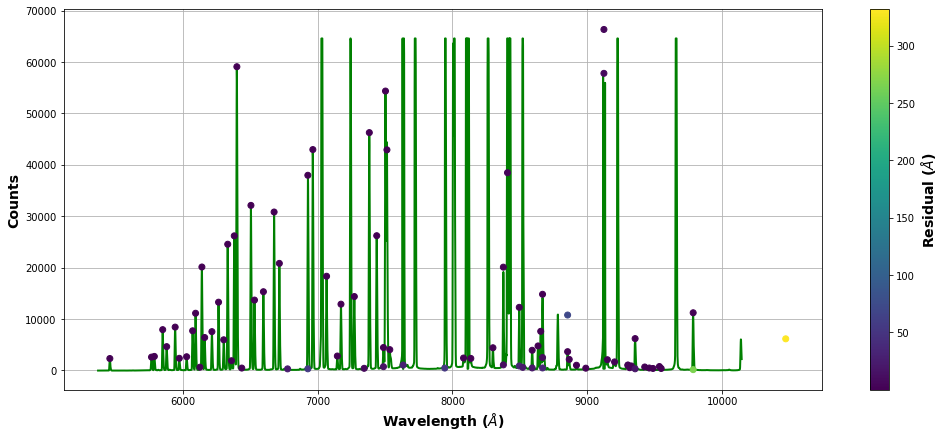

In [73]:
# use the old wavelength solution to identify lines
rough_waves = col_to_wav(coeff, lamp_lines_opt['x'])
lamp_lines_opt['wav'] = match_to_list(linelist['wav'], rough_waves)

# re-fit
coeff2, revcoeff2 = get_wavelength_solution(lamp_lines_opt, order=4)
check_wavelength_solution(lamp_spec_opt, lamp_lines_opt, coeff2)

STD of wavelength residual is 5.9 Angstrom


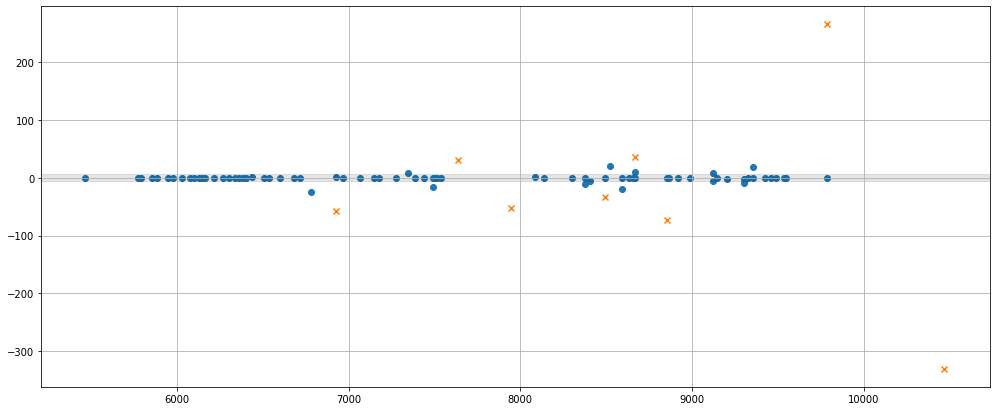

In [74]:
w = lamp_lines_opt['used']
plt.scatter(lamp_lines_opt['wav'][w], lamp_lines_opt['wavres'][w]) #, c=np.abs(lamp_lines['wavres'][w]))
plt.scatter(lamp_lines_opt['wav'][~w], lamp_lines_opt['wavres'][~w], marker='x') #c=np.abs(lamp_lines['wavres'][~w]))
plt.grid()

std = np.std(lamp_lines_opt['wavres'][w], ddof=1)
plt.axhspan(-std, std, color='k', alpha=0.1)
print(f'STD of wavelength residual is {std:0.2} Angstrom')

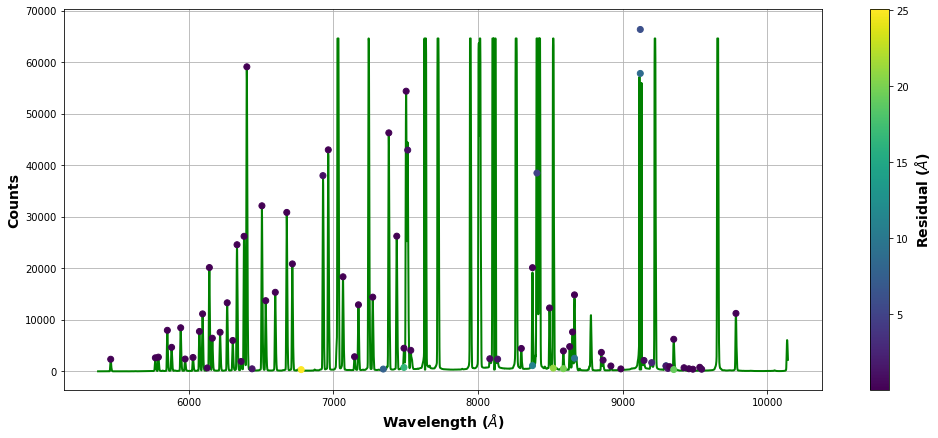

In [75]:
# you may need to exclude strong outliers and re-fit
coeff2, revcoeff2 = get_wavelength_solution(lamp_lines_opt[w], order=4)
check_wavelength_solution(lamp_spec_opt, lamp_lines_opt[w], coeff2)

## Use night sky spectrum to tweak wavelength solution

We need the precise wavelengths of all sky lines. These can be taken from the [UVES sky emission spectrum](https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html), which was constructed through careful analysis of high-resolution spectroscopy. Copies of the UVES nigh sky line lists are provided in the `UVES/` subdirectory of `data/`.

In [76]:
# load skyline list
dtype = []
dtype.append( ('seq', int) )
dtype.append( ('wav', float) )
dtype.append( ('intensity', float) )
dtype.append( ('fwhm', float) )
dtype.append( ('flux', float) )

skylines = np.array([], dtype=dtype)
wildcard = os.path.join(data_dir, 'UVES', '*dat')
fnames = glob(wildcard)
for fname in fnames:
    lines = np.genfromtxt(fname, dtype=dtype, skip_header=3, skip_footer=1)
    skylines = np.hstack([skylines, lines])
    
SKYLINES = skylines

We can convert the line list into a 1-D spectrum by modeling each line as a Gaussian, scaling the Gaussian to the measured line flux, and then adding each line to a continuum. 

In [77]:
# function to convert night sky linelist into spectral template
def model_sky(wav, *params):
    wavshift, scale, fwhm, conta, contb = params
    
    # start with the continuum
    model = np.polyval([conta, contb], wav)
    
    # add in each line
    sigma = fwhm / 2.355
    minwav = np.min(wav) - 3 * fwhm
    maxwav = np.max(wav) + 3 * fwhm
    w = ((SKYLINES['wav'] + wavshift) >= minwav) & ((SKYLINES['wav'] + wavshift) <= maxwav)
    for line in skylines[w]:
        # assume lines are Gaussian
        model += scale * line['flux'] * np.exp( -(wav - line['wav'] - wavshift) ** 2 / 2 / sigma ** 2)
        
    return model

We can compare this model to the data to derive the wavelength drift (and also the instrumental resolution). Start by setting the approximate `scale` and `fwhm` for the data.

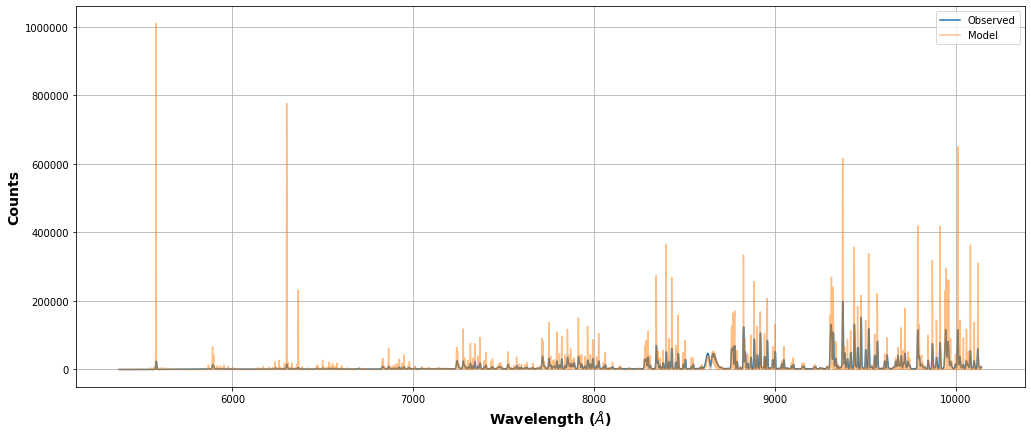

In [78]:
# get starting guess for the fwhm and flux scaling
wavs = col_to_wav(coeff2, np.arange(skybg_opt.size))
params = (0, 1, 2, 0, 0)
skymodel = model_sky(wavs, *params)
w = skymodel > 1
scale = np.mean(skybg_opt[w] / skymodel[w])

plt.plot(wavs, skybg_opt, label='Observed')
plt.plot(wavs, scale * skymodel, label='Model', alpha=0.5)
plt.legend(); plt.grid()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

The `fwhm`, `scale`, etc., will vary with wavelength (note the `fwhm` is related to the instrumental resolution, which is **not** constant with wavelength for most spectrographs!). The wavelength drift may also vary along the spectra, so we should fit for the model parameters in a number of wavelength ranges. Some parts of the spectra may lack significant sky lines, so we should divide up the spectra in a way that ensures each range contains at least a few lines.

Text(0, 0.5, 'Counts')

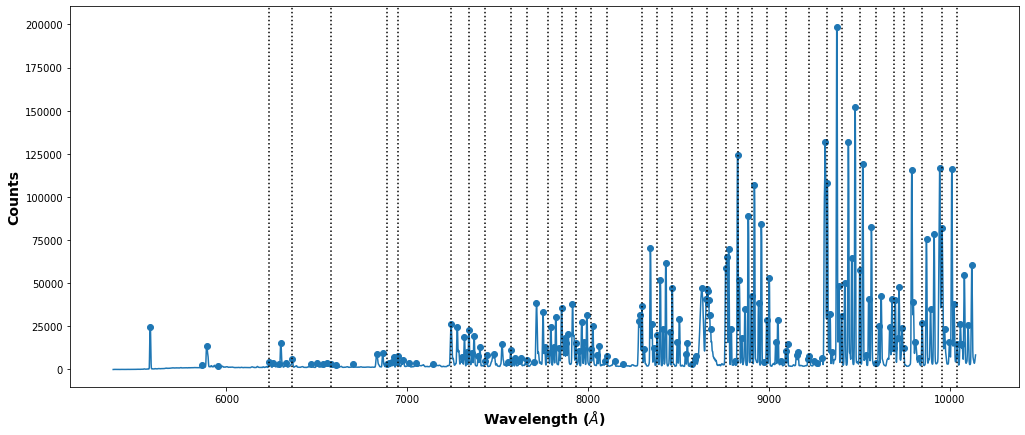

In [79]:
# locate observed sky line peaks (roughly)
skyline_cols, properties = find_peaks(skybg_opt, prominence=1000)
skyline_wavs = col_to_wav(coeff2, skyline_cols)

plt.plot(wavs, skybg_opt, label='Observed')
plt.scatter(skyline_wavs, skybg_opt[skyline_cols]);

# divide into sections with at least a few lines
nmin = 5
minwav = wavs.min()
wavranges = []
while (skyline_wavs > minwav).sum() > nmin:
    w = skyline_wavs > minwav
    maxwav = skyline_wavs[w][nmin - 1]
    dwav = (maxwav - minwav) / 2
    wavranges.append([minwav - dwav, maxwav + dwav])    
    plt.axvline(maxwav, color='k', ls='dotted')
    minwav = maxwav
wavranges.append([maxwav, wavs.max()])
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts')

In each of these `wavranges` find the best set of model parameters to match the observed sky spectrum. As a bonus, you will find the instrumental resolution for each wavelength band as will. 

In [80]:
# fit for the wavelength shift section by section
dtype = []
dtype.append( ('cwav', float) )
dtype.append( ('wavshift', float) )
dtype.append( ('wavshift_err', float) )
dtype.append( ('scale', float) )
dtype.append( ('scale_err', float) )
dtype.append( ('fwhm', float) )
dtype.append( ('fwhm_err', float) )

guess = 0, scale, 5, 0, 0
results = []
for wavrange in wavranges:
    minwav, maxwav = wavrange
    w = (wavs >= minwav) & (wavs < maxwav)
    bounds = ((-50, 0, 0, -np.inf, -np.inf), (50, np.inf, np.inf, np.inf, np.inf))
    popt, pcov = curve_fit(model_sky, wavs[w], skybg_opt[w], p0=guess, bounds=bounds)
    cols = [(minwav + maxwav) / 2]
    for i in range(3):
        cols.append(popt[i])
        cols.append(np.sqrt(np.diag(pcov)[i]))
        
    newrow = np.array(tuple(cols), dtype=dtype)
    results.append(newrow)

results = np.array(results)

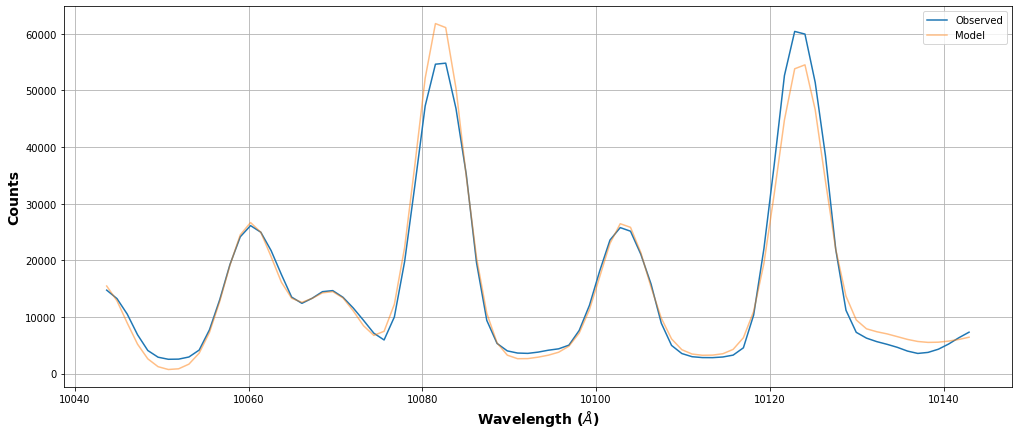

In [81]:
# check the last wavelength range fit
model = model_sky(wavs, *popt)
plt.plot(wavs[w], skybg_opt[w], label='Observed')
plt.plot(wavs[w], model[w], label='Model', alpha=0.5)
plt.legend(); plt.grid()
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

We can fit a polynomial to the measured wavelength shifts so that we can interpolate the results to any wavelength. 

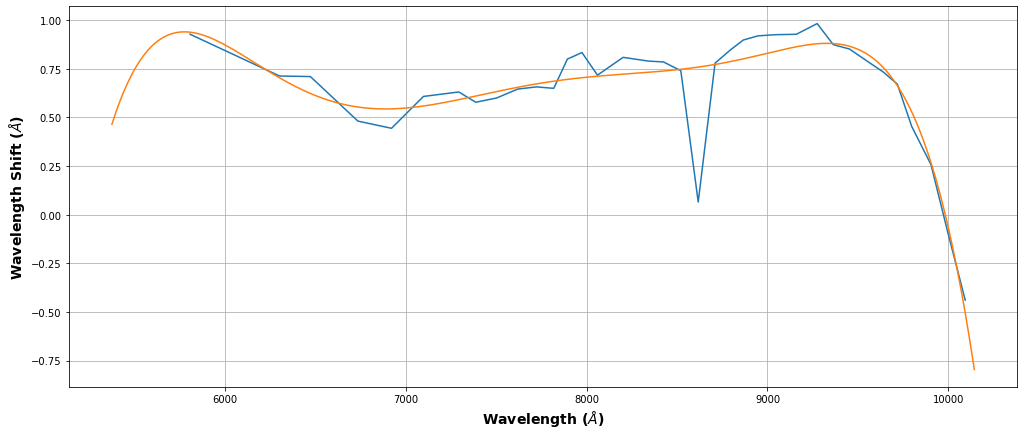

In [82]:
# fit for the wavelength offset
cwavshift = np.polyfit(results['cwav'], results['wavshift'], 6)
plt.plot(results['cwav'], results['wavshift'])
plt.plot(wavs, np.polyval(cwavshift, wavs))
plt.grid()

# correct wavelengths to match skyline values
wavs_corr = wavs - np.polyval(cwavshift, wavs)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Wavelength Shift ($\AA$)');

As a bonus, we can also fit for the instrumental resolving power as a function of wavelength, $R(\lambda) = \lambda / \delta\lambda$.

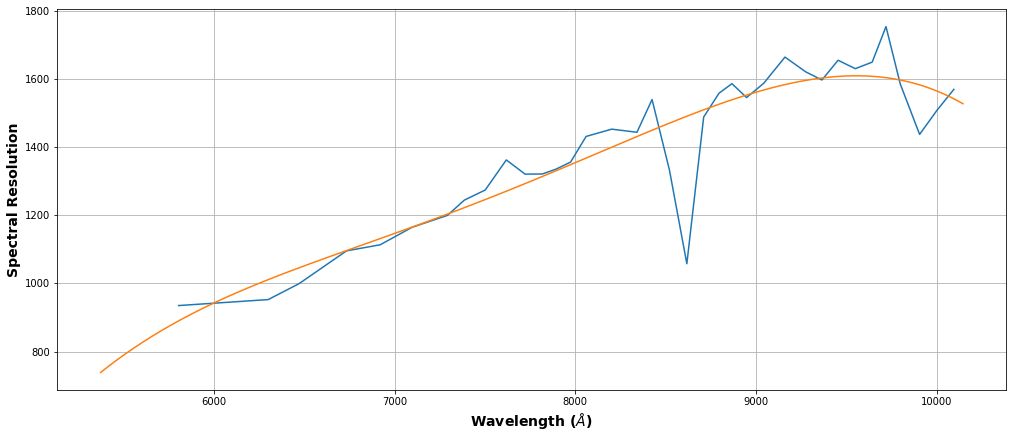

In [83]:
# fit for the resolving power (lambda / fwhm)
cres = np.polyfit(results['cwav'], results['cwav'] / results['fwhm'], 4)
plt.plot(results['cwav'], results['cwav'] / results['fwhm'])
plt.plot(wavs, np.polyval(cres, wavs))
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Spectral Resolution')
plt.grid()

Now that we have the drift-corrected mapping from counts to wavelengths, we can apply this to the full spectrum.

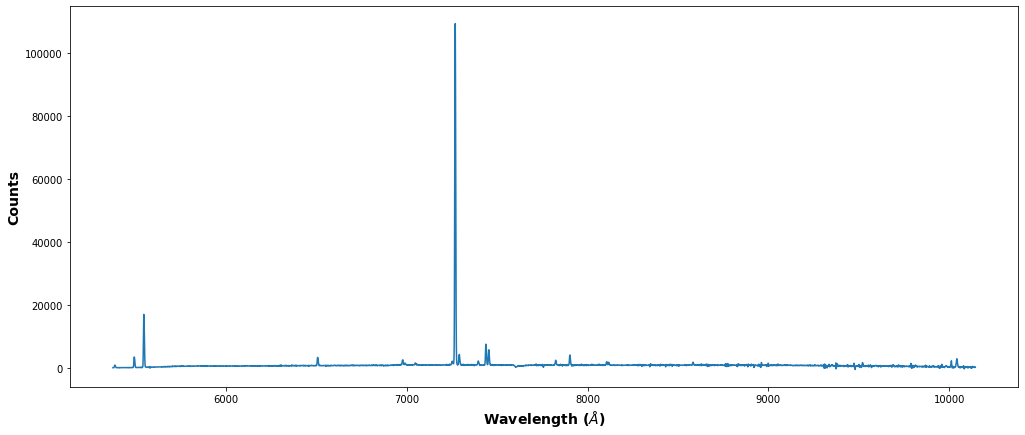

In [84]:
# apply the wavelength solution to the extracted spectrum
plt.plot(wavs_corr, spec_opt);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

<a name="step7"><h1 class="alert alert-info" style="text-align:center;text-decoration: underline">Step 7: Flux Calibration (Optional)</h1></a>

Sometimes you may also want to scale the counts (by a wavelength dependent function) to determine the flux densities in each wavelength bin. To do this, you need to observe a target with a known flux density spectrum. A number of such calibrated standard stars are available and should be observed. Typically you cannot observe your target and a standard star simultaneously, so you need a photometric night in order to get the absolute scaling right. However, even with clouds you can often get the *relative* flux densities of your target.

In [85]:
# extract standard star spectrum as above
stdimage = fits.getdata(os.path.join(data_dir, 'spec_std.fits'))

In [86]:
# compute the row averages and normalize so that the background is near 0 and the peaks are near 1
rowaverage = stdimage.mean(axis=1)
rowaverage -= np.median(rowaverage)
rowaverage /= rowaverage.max()

# find the rows with object light
objrows = ys[rowaverage > 0.01]

# add some margin to object rows
ngrow = 10 # number of rows to include above and below object rows
newobjrows = []
for row in objrows:
    newobjrows.extend([row + i for i in np.arange(-ngrow, ngrow + 1)])
objrows = np.unique(newobjrows)

In [87]:
# mask to mark sky rows
stdskymask = np.ones(stdimage.shape, dtype=bool)
stdskymask[objrows, :] = False

# also exclude bad rows
stdskymask[badrows, :] = False

# median (unmasked) sky spectrum and standard deviation
medspec = np.median(stdimage[skyrows, :], axis=0)
stdspec = np.std(stdimage[skyrows, :], axis=0, ddof=1)

# exclude deviant pixels from the skymask
pull = (stdimage - medspec) / stdspec
w = pull > 3
stdskymask[w] = False

In [88]:
stdskyfit = fit_sky(lambdafit[stdskymask], yvals[stdskymask], stdimage[stdskymask])
stdsky = stdskyfit.ev(lambdafit, yvals)

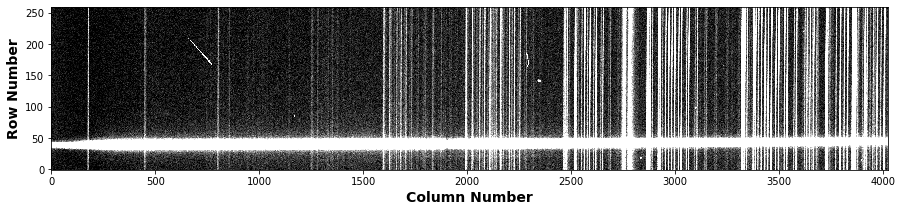

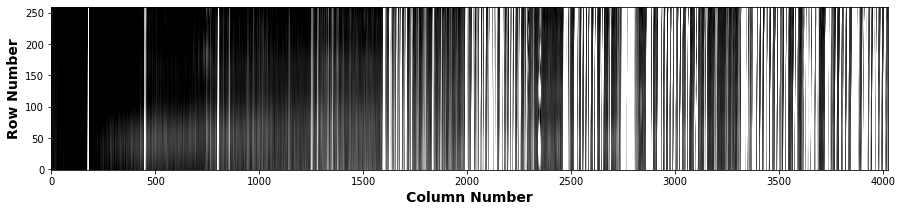

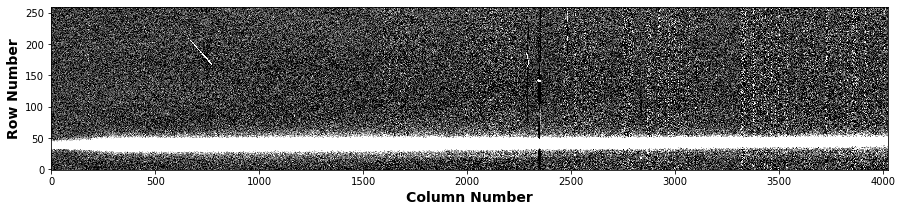

In [89]:
# compare the 2D spectra, background model, and sky subtracted spectra
show_image(stdimage)
show_image(stdsky)
show_image(stdimage - stdsky)

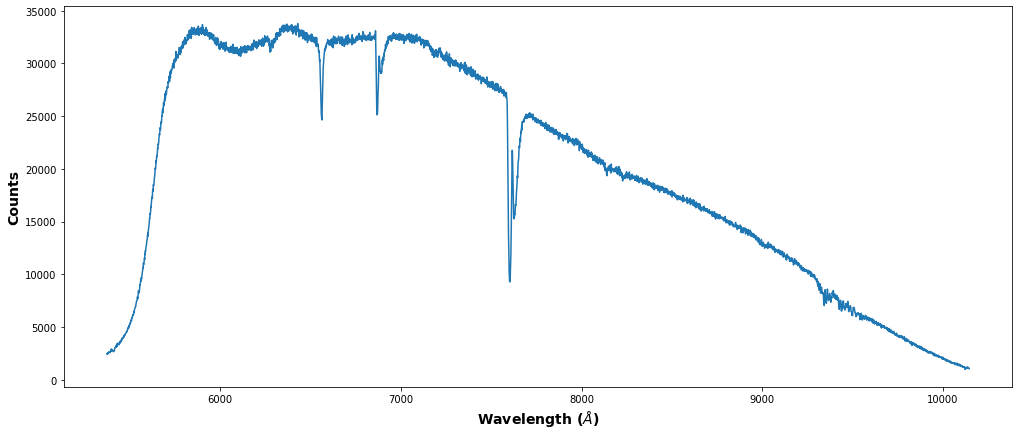

In [90]:
# select which rows to sum
w = (slitpos > -10) & (slitpos < 10)
ymin, ymax = yvals[w].min(), yvals[w].max()

# calculate the sum
std_spec = (stdimage - stdsky)[ymin:ymax, :].sum(axis=0)

# plot the extracted spectrum
plt.plot(wavs_corr, std_spec)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Counts');

The supplied standard star is called Feige 67. You can get a table of its flux densities from [ESO](https://www.eso.org/sci/observing/tools/standards/spectra.html) (and other sources).

In [91]:
# Download the data from ESO
dtype = []
dtype.append( ('wav', float) )
dtype.append( ('flux', float) ) # units are ergs/cm/cm/s/A * 10**16
dtype.append( ('eflux', float) )
dtype.append( ('dlam', float) )
calspec = np.genfromtxt('ftp://ftp.eso.org/pub/stecf/standards/okestan/ffeige67.dat', dtype=dtype)

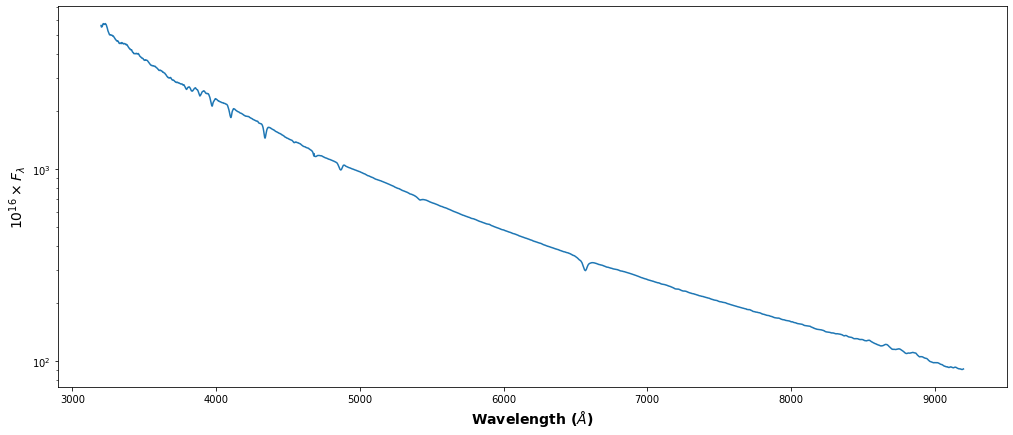

In [92]:
# plot the tabulated flux densities
plt.plot(calspec['wav'], calspec['flux']);
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel(r'$10^{16} \times F_{\lambda}$');
plt.yscale('log');

In [93]:
# fit a spline to the tabulated spectrum
t = np.arange(calspec['wav'][1], calspec['wav'][-2], np.int(np.median(calspec['dlam'])))
stdflux = LSQUnivariateSpline(calspec['wav'], calspec['flux'], t, calspec['eflux'])

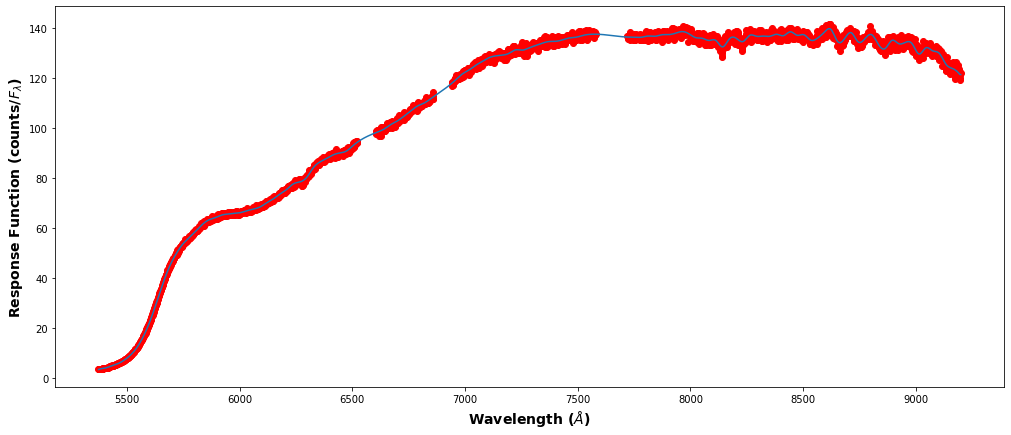

In [94]:
# get the counts to flux density ratios in each wavelength bin
# exclude significant line features (fluxes near these depend on spectral resolution)
ratios = std_spec / stdflux(wavs)
w = (wavs_corr > calspec['wav'].min()) \
    & (wavs_corr < calspec['wav'].max()) \
    & (np.abs(wavs_corr - 7650) > 70) \
    & (np.abs(wavs_corr - 6900) > 40) \
    & (np.abs(wavs_corr - 6563) > 40) \

# fit a spline to the ratios to determine the response function
t = wavs_corr[w][1:-2:25]
respfn = LSQUnivariateSpline(wavs_corr[w], ratios[w], t)

plt.plot(wavs_corr[w], ratios[w], 'ro')
xwav = np.linspace(wavs_corr[w][1], wavs_corr[w][-1], 1000)
plt.plot(xwav, respfn(xwav));
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Response Function (counts/$F_{\lambda}$)');

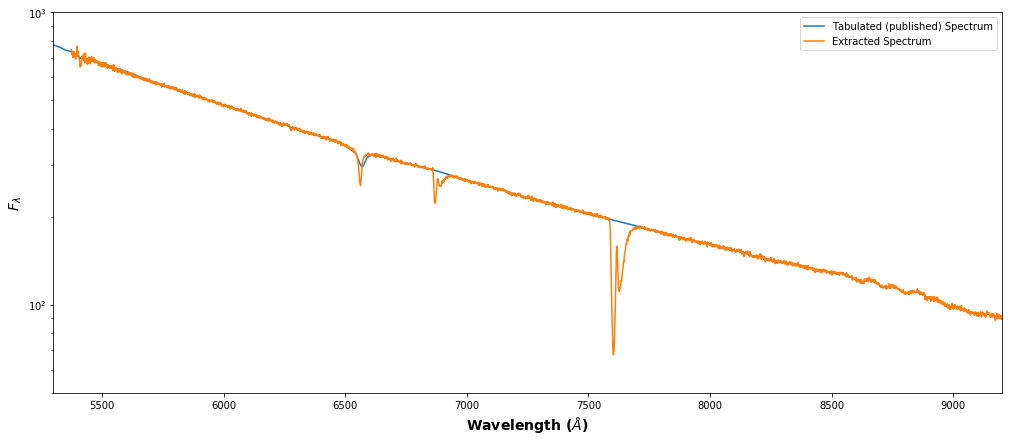

In [95]:
# compare the tabulated and extracted flux densities (applying the response function)
plt.plot(calspec['wav'], calspec['flux'], label='Tabulated (published) Spectrum');
plt.plot(wavs_corr, std_spec / respfn(wavs), label='Extracted Spectrum')
plt.xlim(5300, 9200) # standard star values are only tabulated out to ~9200 A
plt.ylim(0, 1000)

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.ylim(50, 1000)
plt.yscale('log')
plt.legend();

Now apply the response function to the target spectrum to get the flux calibrated spectrum.

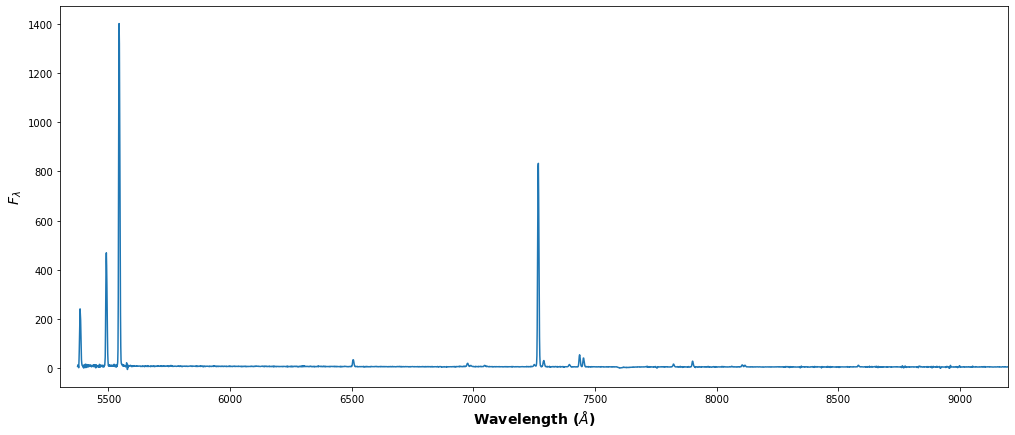

In [96]:
plt.plot(wavs_corr, spec_opt / respfn(wavs))
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$');

<a name="step8">
    <h1 class="alert alert-info" style="text-align:center;text-decoration: underline">
        Step 8: Removal of Telluric Features (Optional)
    </h1>
</a>

The Earth's atmosphere strongly absorbs light in bands near 7600 angstroms (A-band) and 6900 angstroms (B-band), and also in a number of other bands particularly in the near-IR. These bands can be seen in the spectra of our standard star. The target spectrum is also absorbed in these bands. We can correct for this by measuring the fraction of the standard star's light absorbed as a function of wavelength compared to an extrapolation of the standard star's continuum across these bands. We can then scale this absorption strength to match the fractional absorption in the target spectrum and thus divide out the telluric absorption. This works well as long as the atmospheric conditions remain similar.

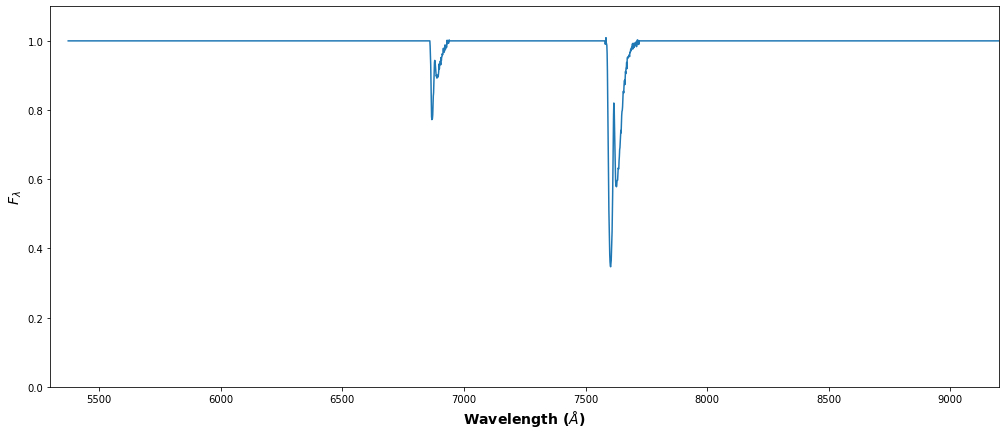

In [97]:
# compute the telluric spectrum (fraction of atmospheric absorption per wavelength bin)
tell_spec = (std_spec / respfn(wavs)) / stdflux(wavs)
w = (np.abs(wavs_corr - 7650) < 70) | (np.abs(wavs_corr - 6900) < 40)
tell_spec[~w] = 1

plt.plot(wavs_corr, tell_spec)
plt.xlim(5300, 9200)
plt.ylim(0, 1.1)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$');

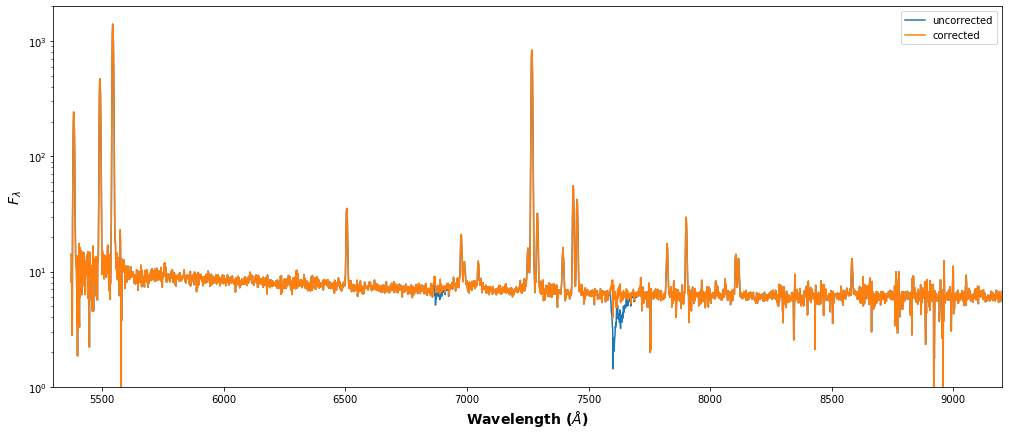

In [98]:
# correct the target spectrum for telluric absorption
plt.plot(wavs_corr, spec_opt / respfn(wavs), label='uncorrected')
plt.plot(wavs_corr, spec_opt / respfn(wavs) / tell_spec, label='corrected')
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.yscale('log')
plt.ylim(1, 2000)
plt.legend();

# Comparison of final results to published spectra

The provided Keck/LRIS spectra have previously been [published](https://ui.adsabs.harvard.edu/#abs/2016ApJ...830...13P/abstract). You can compare your extraction to the 
published spectra, which are available from the [Weizmann Interactive Supernova Data Repository (WISeREP)](https://wiserep.weizmann.ac.il).

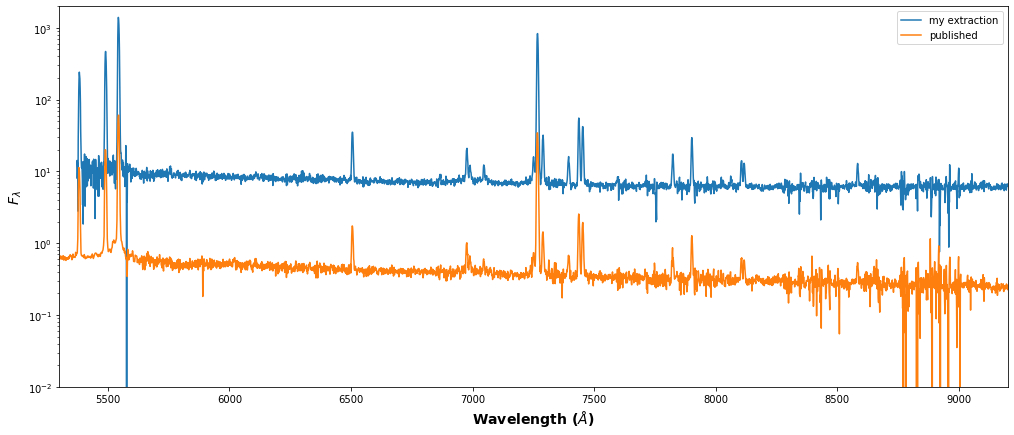

In [99]:
# download the published spectrum
dtype = []
dtype.append( ('wav', float) )
dtype.append( ('flux', float) )
dtype.append( ('sky', float) )
dtype.append( ('eflux', float) )
dtype.append( ('xpix', float) )
dtype.append( ('ypix', float) )
dtype.append( ('resp', float) )
url = 'https://wiserep.weizmann.ac.il/system/files/uploaded/general/PTF12dam_2014-04-30_10-33-34_Keck1_LRIS_None.spec'
pub = np.genfromtxt(url, dtype=dtype)

plt.plot(wavs_corr, spec_opt / respfn(wavs) / tell_spec, label='my extraction')
plt.plot(pub['wav'], pub['flux'] * 1e16, label='published')
plt.xlim(5300, 9200)
plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('$F_{\lambda}$')
plt.yscale('log')
plt.ylim(0.01, 2000)
plt.legend();